In [9]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, r=0.0015)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            weight_m = torch.tensor([1.0e-4, 1.0]).to(self.gpu_or_cpu)
            loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0e-4, 1.0, 1.0e-5]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        # loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        # self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        # print("-----------------------------------------------------------------")
        # print("loss_contour: ", loss_contour.item())
        # # print("loss_tip: ", loss_tip)
        # # print("loss_boundary: ", loss_boundary)
        # print("loss_tip_distance: ", loss_tip_distance.item())
        # # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        # print("motion_model_loss: ", motion_model_loss.item())
        # # print("loss: ", loss)
        # print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [10]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [11]:
def excecute(para_init, i):
    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [ 0.02007997  0.00160014  0.1026283   0.02973628 -0.04668138  0.19240253]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
    #                  dtype=np.float32) # 0, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
    #                  dtype=np.float32) # 1, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815],
    #                  dtype=np.float32) # 2, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0266, 0.2115],
    #                  dtype=np.float32) # 3, diverge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0226, -0.0506, 0.2115],
    #                  dtype=np.float32) # 4
    # para_init = np.array([0.03, 0.0055,  0.0802,  0.0226, -0.0406, 0.2115],
    #                  dtype=np.float32) # 5
    # para_init = np.array([0.0395, 0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.0395, -0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.04, -0.0166,  0.2002,  -0.0006, -0.0266, 0.0345],
    #                  dtype=np.float32)
    # para_init = np.array([0.02, 0.002,  0.1,  0.03, -0.05, 0.2],
    #                  dtype=np.float32)

    # case_naming = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    loss_history = []
    
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
    image_save_path_list = [
    folder_path + 'dof2_c47_0.0005_0.005_0.2_0.01.png',
    folder_path + 'dof2_c46_0.0005_0.001_0.2_0.01.png',
    folder_path + 'dof2_c42_0.0005_-0.0005_0.2_0.01.png',
    folder_path + 'dof2_c56_0.005_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c57_0.005_-0.001_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0.0005, -0.01], [0, 0.004], [0, 0.0015], [-0.0045, 0.0045], [0, -0.004]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs_new/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        # print("Gradients BEFORE BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
        #     else:
        #         print(f"{name}: No gradient computed")

        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        
        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        # print("Gradients AFTER BACKWARD PASS:")
        # for name, param in catheter_optimize_model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
        #     else:
        #         print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        # for name, param in catheter_optimize_model.named_parameters():
        #     print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        # print("Loss: ", loss.item())
        loss_history.append(loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    # for name, param in catheter_optimize_model.named_parameters():
    #     param_numpy = param.data.cpu().numpy()
    #     filename = f"{name}.npy"
    #     np.save(filename, param_numpy)
    #     print(f"Saved {name} to {filename}")
    
    # Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
    iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
    # print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    fig1.suptitle('2D Tip Euclidean Distance Loss History')
    ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
    ax1.set_xlim([0, len(proj_end_effector_loss_history)])
    # ax1.set_ylim([0, 80])
    ax1.grid(True)
    
    filename = f"{i}_2D_loss.png"
    # Specify the full path where you want to save the file
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test2/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig1)  # Close the plot to free up memory


    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    fig2.suptitle('3D Tip Euclidean Distance Loss History')
    ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Euclidean Distance Loss (m)')
    ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
    # ax2.set_ylim([0, 0.05])
    ax2.grid(True)
    
    filename = f"{i}_3D_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test2/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig2)  # Close the plot to free up memory
    
    
    # Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
    iterations_x_axis_loss = list(range(len(loss_history)))
    # print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    fig3.suptitle('Total Loss History')
    ax3.plot(iterations_x_axis_loss, loss_history)
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss Value')
    ax3.set_xlim([0, len(loss_history)])
    ax3.set_ylim([0, 3e5])
    ax3.grid(True)
    
    filename = f"{i}_total_loss.png"
    full_path = f"E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/figs/test2/{filename}" 
    # Save the figure
    plt.savefig(full_path)
    
    plt.show()
    plt.close(fig3)  # Close the plot to free up memory

In [12]:
def generate_random_vector(distance_range, size=3):
    """生成指定距离范围内的随机向量"""
    magnitude = np.random.uniform(*distance_range)
    direction = np.random.normal(size=size)
    unit_vector = direction / np.linalg.norm(direction)
    return unit_vector * magnitude

# 定义 ground truth 向量
ground_truth = np.array([0.02007997, 0.00160014, 0.1026283, 0.02973628, -0.04668138, 0.19240253])

# 生成 15 个向量
num_vectors = 20
vectors = []

for _ in range(num_vectors):
    # 前三个元素的随机偏移
    offset_front = generate_random_vector((0.005, 0.03), 3)
    # 后三个元素的随机偏移
    offset_back = generate_random_vector((0.005, 0.05), 3)
    
    # 应用偏移并存储向量
    new_vector = ground_truth + np.concatenate((offset_front, offset_back))
    vectors.append(new_vector)

# 根据后三个元素的欧几里得距离从小到大排序
vectors.sort(key=lambda x: np.linalg.norm(x[3:6] - ground_truth[3:6]))

# 打印结果，同时显示与 ground truth 的距离
for vec in vectors:
    distance_front = np.linalg.norm(vec[:3] - ground_truth[:3])
    distance_back = np.linalg.norm(vec[3:6] - ground_truth[3:6])
    print(f"Vector: {vec}")
    print(f"Distance Front 3: {distance_front:.4f}, Distance Back 3: {distance_back:.4f}\n")

Vector: [ 0.02605807  0.0092568   0.09785173  0.02757177 -0.05603672  0.20167775]
Distance Front 3: 0.0108, Distance Back 3: 0.0134

Vector: [ 0.02441305  0.00881973  0.10178207  0.03334903 -0.05903055  0.19596727]
Distance Front 3: 0.0085, Distance Back 3: 0.0134

Vector: [ 0.02104341  0.0127817   0.12863825  0.041598   -0.04093696  0.20217262]
Distance Front 3: 0.0283, Distance Back 3: 0.0164

Vector: [ 0.02320778 -0.01176014  0.11890241  0.01599777 -0.04472673  0.20165155]
Distance Front 3: 0.0213, Distance Back 3: 0.0167

Vector: [ 0.00389588  0.01467602  0.1052592   0.02279014 -0.06299337  0.19699218]
Distance Front 3: 0.0210, Distance Back 3: 0.0183

Vector: [ 0.0031698  -0.00737413  0.10884649  0.02143483 -0.05976279  0.18050192]
Distance Front 3: 0.0201, Distance Back 3: 0.0195

Vector: [-0.00573178 -0.00769662  0.09519193  0.02522521 -0.06434337  0.19978027]
Distance Front 3: 0.0284, Distance Back 3: 0.0197

Vector: [ 0.03810904 -0.01507456  0.11046302  0.04040614 -0.03019282 

23
Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:02<03:48,  2.31s/it, loss=1.34e+5]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:04<03:47,  2.33s/it, loss=4.02e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:07<03:58,  2.46s/it, loss=1.07e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:10<04:17,  2.68s/it, loss=2.53e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:13<04:29,  2.84s/it, loss=4.83e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:16<04:41,  3.00s/it, loss=605]    


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:20<05:14,  3.38s/it, loss=1.07e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:24<05:26,  3.55s/it, loss=3.51e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:28<05:35,  3.69s/it, loss=6.44e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:33<05:52,  3.92s/it, loss=1.87e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:37<06:11,  4.17s/it, loss=1.1e+4] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:42<06:22,  4.35s/it, loss=1.35e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:47<06:35,  4.54s/it, loss=1.53e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:53<06:58,  4.87s/it, loss=4.67e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:58<07:09,  5.06s/it, loss=1.93e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [01:04<07:22,  5.27s/it, loss=1.76e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [01:10<07:33,  5.46s/it, loss=1.77e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:16<07:45,  5.67s/it, loss=2.53e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:23<07:58,  5.91s/it, loss=3.14e+5]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:29<08:02,  6.03s/it, loss=1.38e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:36<08:11,  6.22s/it, loss=4.95e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:43<08:31,  6.56s/it, loss=1.05e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:50<08:43,  6.80s/it, loss=8.91e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:57<08:33,  6.76s/it, loss=7.64e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [02:05<08:54,  7.13s/it, loss=6.81e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [02:13<09:00,  7.31s/it, loss=5.1e+3] 


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [02:21<09:20,  7.67s/it, loss=4.32e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:30<09:33,  7.96s/it, loss=3.33e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:38<09:35,  8.11s/it, loss=8.99e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:47<09:39,  8.28s/it, loss=1.73e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:57<09:58,  8.67s/it, loss=5.78e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [03:06<10:05,  8.91s/it, loss=1.19e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [03:16<10:12,  9.13s/it, loss=2.58e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [03:26<10:19,  9.38s/it, loss=1.07e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [03:36<10:28,  9.67s/it, loss=1.07e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:47<10:40, 10.01s/it, loss=1.33e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:58<10:46, 10.26s/it, loss=1.36e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [04:09<10:51, 10.51s/it, loss=4.01e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [04:20<10:57, 10.79s/it, loss=1.47e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [04:32<11:06, 11.11s/it, loss=1.79e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [04:44<11:09, 11.35s/it, loss=1.61e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [04:56<11:13, 11.62s/it, loss=1.45e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [05:08<10:59, 11.57s/it, loss=1.45e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [05:18<10:25, 11.16s/it, loss=4.46e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [05:28<09:59, 10.91s/it, loss=1.14e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [05:38<09:37, 10.70s/it, loss=1.83e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [05:49<09:25, 10.66s/it, loss=970]    


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [06:00<09:16, 10.71s/it, loss=1.06e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [06:11<09:08, 10.75s/it, loss=985]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [06:22<09:01, 10.82s/it, loss=762]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [06:33<08:59, 11.01s/it, loss=809]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [06:45<08:59, 11.25s/it, loss=1.06e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [06:57<09:00, 11.50s/it, loss=683]    


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [07:09<08:56, 11.67s/it, loss=1.25e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [07:21<08:50, 11.78s/it, loss=785]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [07:33<08:45, 11.95s/it, loss=905]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [07:46<08:38, 12.05s/it, loss=621]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [07:58<08:34, 12.25s/it, loss=667]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [08:11<08:32, 12.49s/it, loss=4.04e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [08:25<08:28, 12.71s/it, loss=665]    


loop_id:  60


Optimizing:  61%|██████    | 61/100 [08:38<08:26, 13.00s/it, loss=4.82e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [08:52<08:25, 13.31s/it, loss=606]    


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [09:07<08:22, 13.57s/it, loss=689]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [09:21<08:19, 13.88s/it, loss=566]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [09:35<08:07, 13.93s/it, loss=914]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [09:49<07:57, 14.04s/it, loss=606]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [10:04<07:45, 14.11s/it, loss=547]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [10:18<07:34, 14.22s/it, loss=659]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [10:33<07:25, 14.36s/it, loss=2.04e+5]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [10:48<07:15, 14.51s/it, loss=544]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [11:03<07:05, 14.68s/it, loss=721]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [11:18<06:55, 14.85s/it, loss=3.34e+5]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [11:33<06:45, 15.02s/it, loss=1.44e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [11:49<06:35, 15.20s/it, loss=771]    


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [12:05<06:26, 15.46s/it, loss=573]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [12:21<06:14, 15.62s/it, loss=502]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [12:38<06:04, 15.84s/it, loss=511]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [12:54<05:51, 15.97s/it, loss=625]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [13:10<05:39, 16.18s/it, loss=505]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [13:27<05:26, 16.33s/it, loss=479]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [13:44<05:12, 16.46s/it, loss=2.43e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [14:01<04:59, 16.66s/it, loss=502]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [14:18<04:46, 16.87s/it, loss=474]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [14:36<04:32, 17.04s/it, loss=470]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [14:54<04:18, 17.23s/it, loss=513]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [15:11<04:03, 17.38s/it, loss=485]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [15:29<03:49, 17.62s/it, loss=1.53e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [15:48<03:33, 17.80s/it, loss=525]    


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [16:06<03:17, 17.94s/it, loss=564]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [16:25<03:02, 18.20s/it, loss=707]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [16:43<02:44, 18.31s/it, loss=1.02e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [17:02<02:27, 18.47s/it, loss=580]    


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [17:21<02:10, 18.62s/it, loss=3.37e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [17:41<01:53, 18.86s/it, loss=482]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [18:00<01:35, 19.04s/it, loss=620]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [18:20<01:16, 19.25s/it, loss=3.03e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [18:40<00:58, 19.60s/it, loss=560]    


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [19:01<00:39, 19.96s/it, loss=603]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [19:21<00:20, 20.06s/it, loss=1.2e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [19:42<00:00, 11.83s/it, loss=505]  


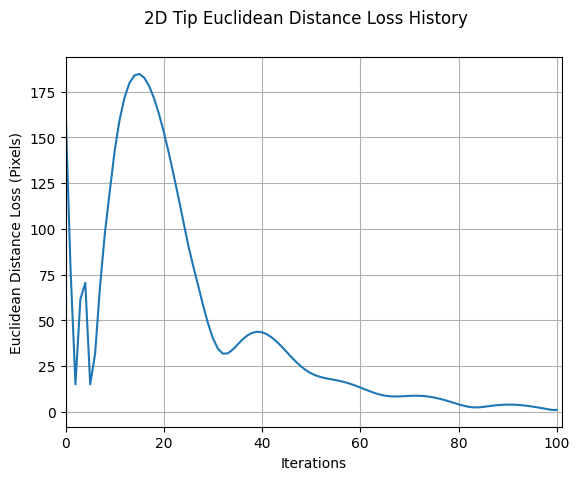

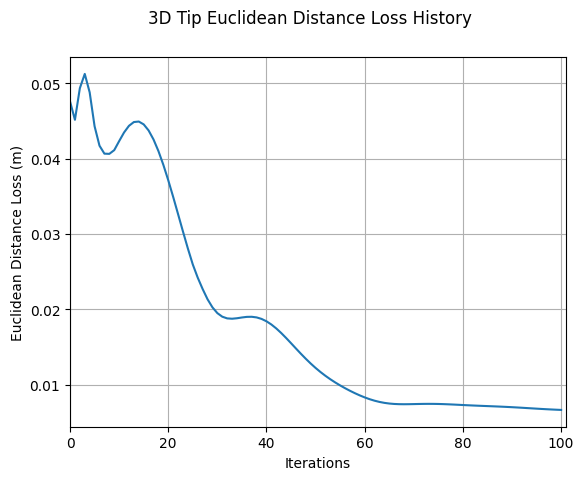

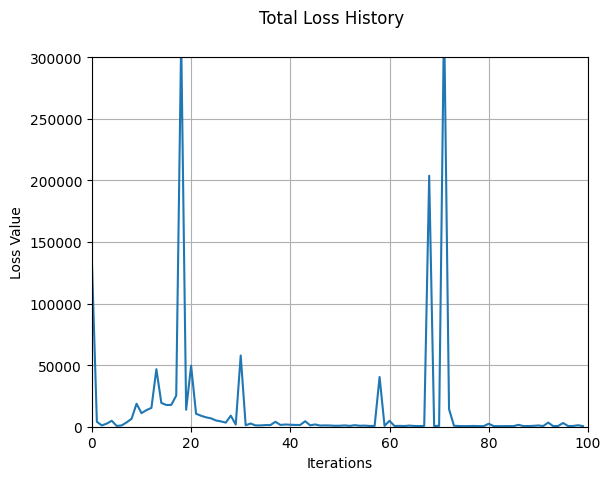

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:56,  1.79s/it, loss=6.16e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:07,  1.91s/it, loss=4.31e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:17,  2.04s/it, loss=3.44e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:27,  2.16s/it, loss=1.52e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:41,  2.33s/it, loss=529]    


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:48,  2.43s/it, loss=1.41e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:02,  2.61s/it, loss=1.54e+4]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:31,  2.95s/it, loss=1.83e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:38,  3.06s/it, loss=1.18e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:48,  3.20s/it, loss=874]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:00,  3.38s/it, loss=2.8e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:08,  3.51s/it, loss=1.18e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:18,  3.66s/it, loss=3.17e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:31,  3.86s/it, loss=1.75e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:41,  4.02s/it, loss=1.16e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:52,  4.20s/it, loss=845]    


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:03,  4.38s/it, loss=616]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:16,  4.59s/it, loss=1.51e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:22,  4.72s/it, loss=561]    


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:32,  4.90s/it, loss=663]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:44,  5.11s/it, loss=1.3e+5]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:53,  5.30s/it, loss=779]   


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<07:06,  5.54s/it, loss=637]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:14,  5.71s/it, loss=985]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:42<07:21,  5.89s/it, loss=505]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:48<07:30,  6.09s/it, loss=455]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:55<07:38,  6.27s/it, loss=1.7e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:02<07:46,  6.48s/it, loss=2.21e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:09<07:54,  6.69s/it, loss=615]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:16<07:59,  6.85s/it, loss=616]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:24<08:06,  7.05s/it, loss=576]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:31<08:12,  7.25s/it, loss=475]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:39<08:18,  7.44s/it, loss=446]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:47<08:21,  7.60s/it, loss=454]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:56<08:26,  7.80s/it, loss=462]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:04<08:32,  8.00s/it, loss=450]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:13<08:38,  8.23s/it, loss=452]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:21<08:39,  8.37s/it, loss=465]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:30<08:41,  8.54s/it, loss=2.91e+6]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:39<08:41,  8.70s/it, loss=482]    


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:49<08:43,  8.88s/it, loss=839]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:59<08:50,  9.15s/it, loss=421]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:08<08:51,  9.32s/it, loss=512]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:18<08:55,  9.56s/it, loss=415]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:28<08:53,  9.70s/it, loss=602]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:39<08:53,  9.88s/it, loss=477]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:49<08:51, 10.03s/it, loss=6.37e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [05:00<08:50, 10.20s/it, loss=463]    


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:10<08:48, 10.37s/it, loss=418]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:22<08:50, 10.61s/it, loss=422]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:33<08:48, 10.79s/it, loss=1.25e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:44<08:44, 10.92s/it, loss=1.38e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:56<08:41, 11.09s/it, loss=784]    


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:07<08:37, 11.26s/it, loss=5.07e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:19<08:33, 11.41s/it, loss=490]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:31<08:33, 11.68s/it, loss=396]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:44<08:29, 11.85s/it, loss=4.49e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:56<08:25, 12.04s/it, loss=463]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:09<08:20, 12.20s/it, loss=424]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:21<08:13, 12.35s/it, loss=502]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:34<08:09, 12.55s/it, loss=531]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:48<08:08, 12.85s/it, loss=522]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [08:01<08:03, 13.07s/it, loss=402]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:15<07:57, 13.26s/it, loss=424]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:30<07:55, 13.59s/it, loss=673]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:44<07:48, 13.78s/it, loss=523]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:58<07:39, 13.93s/it, loss=2.42e+5]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:13<07:33, 14.18s/it, loss=387]    


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:27<07:23, 14.30s/it, loss=491]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:42<07:13, 14.46s/it, loss=587]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:57<07:05, 14.69s/it, loss=505]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:12<06:54, 14.80s/it, loss=474]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:28<06:43, 14.95s/it, loss=424]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:44<06:39, 15.35s/it, loss=418]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [11:01<06:32, 15.69s/it, loss=1.78e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:17<06:23, 15.96s/it, loss=385]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:33<06:08, 16.01s/it, loss=440]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:50<05:55, 16.17s/it, loss=2.33e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [12:06<05:42, 16.31s/it, loss=649]    


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:23<05:27, 16.38s/it, loss=385]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:41<05:19, 16.80s/it, loss=389]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:58<05:05, 16.97s/it, loss=402]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:15<04:49, 17.03s/it, loss=517]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:33<04:33, 17.12s/it, loss=1.36e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:50<04:20, 17.34s/it, loss=431]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [14:08<04:05, 17.53s/it, loss=560]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:27<03:51, 17.84s/it, loss=725]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:46<03:37, 18.13s/it, loss=414]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [15:05<03:22, 18.42s/it, loss=447]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:24<03:06, 18.61s/it, loss=396]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:43<02:49, 18.80s/it, loss=641]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [16:05<02:36, 19.60s/it, loss=1.5e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:24<02:16, 19.55s/it, loss=389]   


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:44<01:57, 19.53s/it, loss=1.6e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [17:03<01:37, 19.50s/it, loss=534]   


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:23<01:17, 19.50s/it, loss=432]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:42<00:58, 19.61s/it, loss=493]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [18:03<00:39, 19.79s/it, loss=906]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [18:23<00:19, 19.85s/it, loss=4.18e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:43<00:00, 11.24s/it, loss=549]   


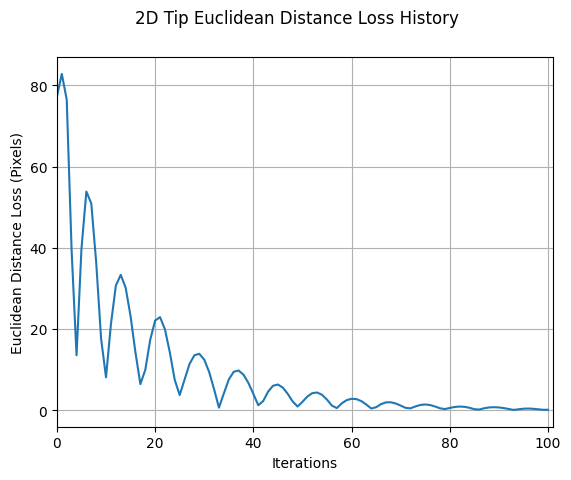

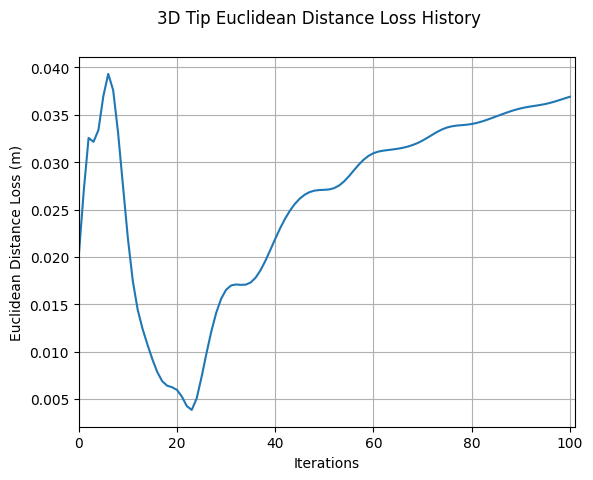

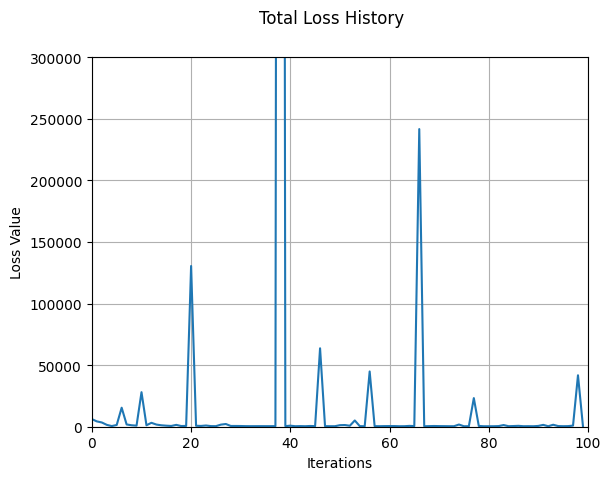

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:58,  1.80s/it, loss=5.27e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:03,  1.88s/it, loss=3.57e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:18,  2.05s/it, loss=2.6e+3] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:26,  2.15s/it, loss=1.79e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:39,  2.31s/it, loss=1.62e+4]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:52,  2.47s/it, loss=1.01e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:03,  2.62s/it, loss=4.83e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:18,  2.81s/it, loss=8.45e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:32,  2.99s/it, loss=1.15e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:44,  3.16s/it, loss=1.27e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:57,  3.34s/it, loss=1.19e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:09,  3.51s/it, loss=1.22e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:17,  3.65s/it, loss=1.22e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:30,  3.84s/it, loss=2.1e+4] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:51,  4.14s/it, loss=1.24e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:52<06:03,  4.33s/it, loss=7.07e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:57<06:12,  4.48s/it, loss=6.98e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:02<06:18,  4.62s/it, loss=3.24e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:07<06:28,  4.80s/it, loss=7.44e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:34,  4.93s/it, loss=3.83e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:18<06:44,  5.12s/it, loss=5.15e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:51,  5.28s/it, loss=6.36e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<07:00,  5.46s/it, loss=1.07e+4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:07,  5.62s/it, loss=8.36e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:16,  5.82s/it, loss=8.16e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:48<07:24,  6.01s/it, loss=6.15e+6]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:32,  6.20s/it, loss=8.94e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:42,  6.42s/it, loss=7.45e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:08<07:47,  6.59s/it, loss=7.75e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:16<08:02,  6.89s/it, loss=9.71e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:24<08:09,  7.10s/it, loss=9.09e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:31<08:14,  7.27s/it, loss=8.42e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:39<08:19,  7.45s/it, loss=8.18e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:47<08:24,  7.64s/it, loss=1.33e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:55<08:27,  7.81s/it, loss=7.53e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:04<08:32,  8.01s/it, loss=8.53e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:12<08:35,  8.18s/it, loss=1.81e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:21<08:35,  8.32s/it, loss=3.92e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:30<08:38,  8.50s/it, loss=3.84e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:39<08:39,  8.66s/it, loss=5.61e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:48<08:42,  8.85s/it, loss=5.33e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:58<08:44,  9.05s/it, loss=4.15e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:08<08:47,  9.26s/it, loss=3.2e+3] 


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:17<08:47,  9.42s/it, loss=8.25e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:28<08:49,  9.63s/it, loss=5.14e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:38<08:51,  9.85s/it, loss=1.18e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:48<08:51, 10.03s/it, loss=1.47e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:59<08:50, 10.20s/it, loss=1.56e+4]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:10<08:48, 10.36s/it, loss=1.87e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:21<08:54, 10.68s/it, loss=2.19e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:33<08:56, 10.94s/it, loss=2.44e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:44<08:50, 11.05s/it, loss=2.61e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:56<08:47, 11.22s/it, loss=3.36e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:07<08:42, 11.37s/it, loss=4.5e+4] 


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:19<08:39, 11.54s/it, loss=5.06e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:31<08:33, 11.68s/it, loss=6.15e+4]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:43<08:29, 11.85s/it, loss=6.83e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:56<08:22, 11.97s/it, loss=7.57e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:08<08:16, 12.11s/it, loss=8.04e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:21<08:10, 12.27s/it, loss=8.56e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:34<08:06, 12.47s/it, loss=8.86e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:47<08:05, 12.76s/it, loss=9.14e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [08:01<07:59, 12.97s/it, loss=9.34e+4]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:14<07:54, 13.17s/it, loss=9.37e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:28<07:48, 13.38s/it, loss=9.41e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:42<07:43, 13.62s/it, loss=9.48e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:57<07:36, 13.82s/it, loss=9.69e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:11<07:28, 14.01s/it, loss=9.22e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:26<07:20, 14.20s/it, loss=9.17e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:41<07:15, 14.50s/it, loss=8.92e+4]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:56<07:05, 14.67s/it, loss=8.74e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:11<06:54, 14.80s/it, loss=8.59e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:26<06:43, 14.96s/it, loss=8.41e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:42<06:35, 15.19s/it, loss=8.96e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:58<06:23, 15.35s/it, loss=8.01e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:14<06:14, 15.61s/it, loss=7.81e+4]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:30<06:03, 15.79s/it, loss=7.62e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:47<05:51, 15.95s/it, loss=7.45e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [12:03<05:38, 16.11s/it, loss=7.28e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:20<05:26, 16.30s/it, loss=7.12e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:37<05:12, 16.47s/it, loss=6.91e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:54<05:00, 16.67s/it, loss=7.84e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:11<04:46, 16.86s/it, loss=6.57e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:29<04:32, 17.03s/it, loss=6.41e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:46<04:17, 17.15s/it, loss=6.34e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [14:04<04:03, 17.39s/it, loss=6.1e+4] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:22<03:48, 17.55s/it, loss=5.94e+4]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:40<03:33, 17.76s/it, loss=5.82e+4]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:58<03:16, 17.91s/it, loss=5.64e+4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:17<03:01, 18.17s/it, loss=5.49e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:36<02:44, 18.31s/it, loss=5.35e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:55<02:28, 18.53s/it, loss=5.22e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:14<02:11, 18.79s/it, loss=5.05e+4]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:34<01:53, 18.95s/it, loss=1.25e+6]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:53<01:35, 19.12s/it, loss=4.93e+4]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:13<01:17, 19.31s/it, loss=1.06e+5]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:33<00:58, 19.52s/it, loss=4.52e+4]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:53<00:39, 19.68s/it, loss=4.36e+4]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [18:13<00:19, 19.82s/it, loss=4.2e+4] 


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:33<00:00, 11.14s/it, loss=4.07e+4]


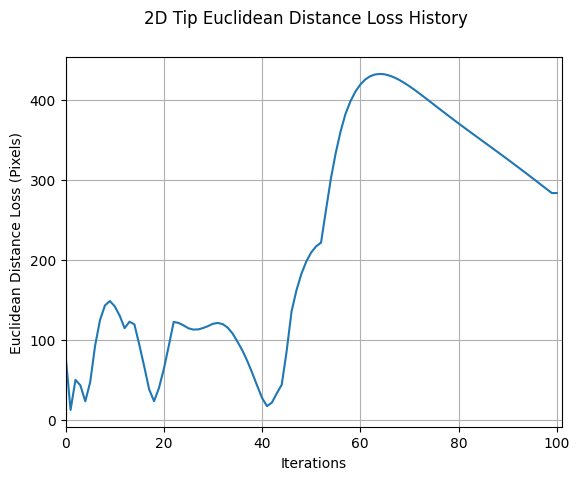

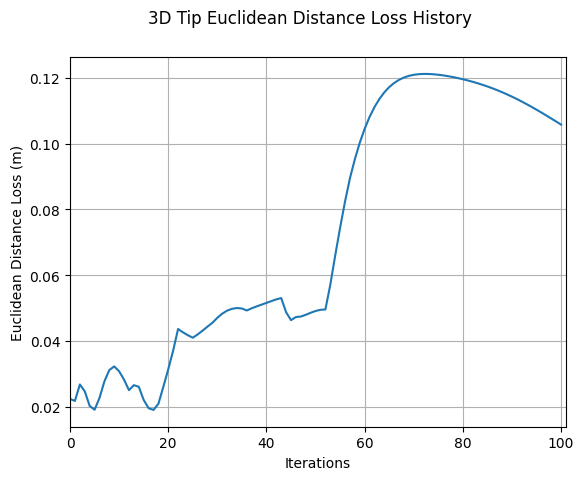

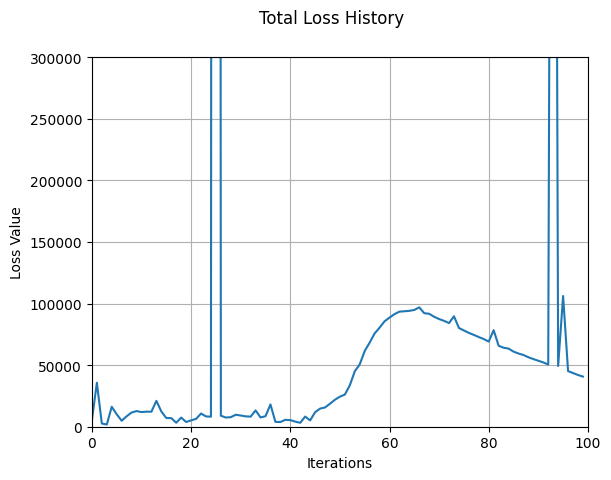

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<03:00,  1.82s/it, loss=6.59e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:09,  1.94s/it, loss=2.17e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:19,  2.06s/it, loss=3.1e+4] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:26,  2.15s/it, loss=6.9e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:37,  2.29s/it, loss=1.4e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:49,  2.44s/it, loss=9.32e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:17<04:16,  2.76s/it, loss=8.96e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:28,  2.91s/it, loss=2.01e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:40,  3.09s/it, loss=2.7e+3] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:50,  3.23s/it, loss=1.78e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:00,  3.38s/it, loss=1.36e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:10,  3.53s/it, loss=4.96e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:20,  3.69s/it, loss=543]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:43<05:29,  3.84s/it, loss=987]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:41,  4.01s/it, loss=1.58e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:52<05:56,  4.25s/it, loss=2.03e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:57<06:12,  4.49s/it, loss=2.29e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:02<06:21,  4.66s/it, loss=2.41e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:07<06:33,  4.85s/it, loss=2.24e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:13<06:42,  5.03s/it, loss=1.83e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:18<06:50,  5.20s/it, loss=2.98e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:24<07:01,  5.40s/it, loss=7.32e+5]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:30<07:08,  5.56s/it, loss=1.38e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:36<07:14,  5.72s/it, loss=783]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:43<07:24,  5.92s/it, loss=997]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:49<07:31,  6.10s/it, loss=781]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:56<07:42,  6.34s/it, loss=957]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:03<07:51,  6.54s/it, loss=6.14e+5]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:10<07:55,  6.70s/it, loss=1.08e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:17<07:57,  6.82s/it, loss=2.39e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:25<08:01,  6.97s/it, loss=1.09e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:32<08:05,  7.15s/it, loss=845]    


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:40<08:10,  7.32s/it, loss=844]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:47<08:10,  7.44s/it, loss=2.22e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:56<08:15,  7.62s/it, loss=750]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:04<08:20,  7.82s/it, loss=505]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:12<08:26,  8.05s/it, loss=525]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:21<08:27,  8.19s/it, loss=544]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:30<08:27,  8.33s/it, loss=598]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:39<08:34,  8.57s/it, loss=1.56e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:48<08:36,  8.75s/it, loss=5.58e+4]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:57<08:35,  8.88s/it, loss=676]    


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:07<08:37,  9.09s/it, loss=566]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:16<08:40,  9.30s/it, loss=654]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:26<08:39,  9.45s/it, loss=1.52e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:36<08:37,  9.58s/it, loss=494]    


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:46<08:38,  9.77s/it, loss=801]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:57<08:37,  9.95s/it, loss=754]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:07<08:38, 10.16s/it, loss=478]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:18<08:41, 10.42s/it, loss=8.87e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:29<08:37, 10.56s/it, loss=738]    


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:40<08:34, 10.71s/it, loss=3.39e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:52<08:30, 10.86s/it, loss=478]    


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:03<08:27, 11.03s/it, loss=736]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:23, 11.18s/it, loss=424]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:22, 11.43s/it, loss=1.33e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:39<08:19, 11.61s/it, loss=537]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:51<08:14, 11.76s/it, loss=3.72e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:09, 11.94s/it, loss=465]    


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:16<08:05, 12.14s/it, loss=469]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:28<08:01, 12.35s/it, loss=4.08e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:42<07:59, 12.61s/it, loss=444]    


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:55<07:56, 12.88s/it, loss=3.83e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:09<07:49, 13.04s/it, loss=442]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:22<07:42, 13.20s/it, loss=524]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:36<07:37, 13.46s/it, loss=1.02e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:50<07:29, 13.61s/it, loss=417]    


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:04<07:20, 13.76s/it, loss=1.85e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:19<07:11, 13.93s/it, loss=515]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:33<07:03, 14.12s/it, loss=412]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:48<06:56, 14.36s/it, loss=1.54e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:03<06:46, 14.52s/it, loss=942]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:18<06:36, 14.67s/it, loss=414]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:33<06:24, 14.78s/it, loss=412]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:49<06:15, 15.01s/it, loss=1.17e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:04<06:02, 15.12s/it, loss=3.55e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:20<05:52, 15.31s/it, loss=4.53e+5]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:36<05:40, 15.46s/it, loss=3.94e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:52<05:29, 15.67s/it, loss=529]    


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:08<05:17, 15.87s/it, loss=674]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:25<05:05, 16.06s/it, loss=407]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:41<04:52, 16.23s/it, loss=406]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:58<04:39, 16.44s/it, loss=757]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:15<04:26, 16.64s/it, loss=526]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:32<04:11, 16.74s/it, loss=679]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:50<03:56, 16.92s/it, loss=406]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:07<03:43, 17.17s/it, loss=1.4e+5]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:25<03:28, 17.34s/it, loss=791]   


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:43<03:12, 17.52s/it, loss=2.12e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:01<02:57, 17.70s/it, loss=514]    


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:20<02:41, 17.98s/it, loss=564]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:38<02:25, 18.21s/it, loss=470]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:57<02:08, 18.31s/it, loss=419]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:16<01:51, 18.54s/it, loss=527]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:35<01:33, 18.68s/it, loss=406]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:54<01:15, 18.79s/it, loss=460]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:14<00:56, 18.98s/it, loss=431]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:33<00:38, 19.27s/it, loss=407]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:53<00:19, 19.39s/it, loss=4.65e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:13<00:00, 10.93s/it, loss=1.32e+3]


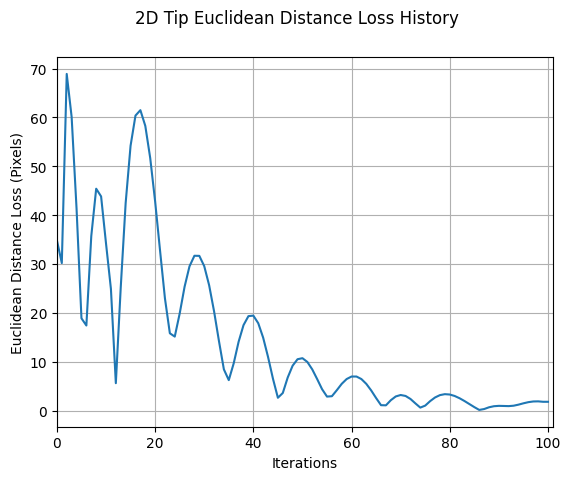

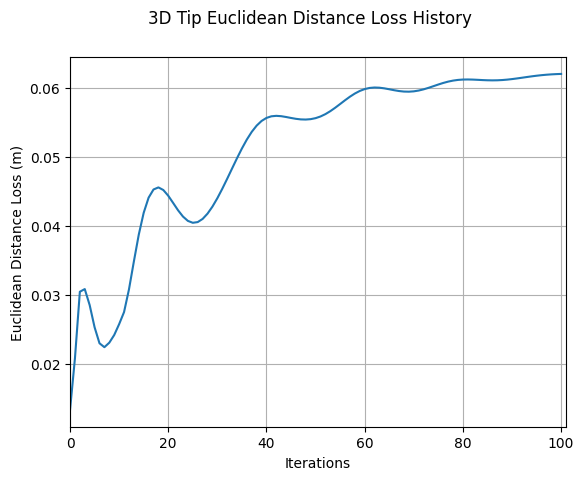

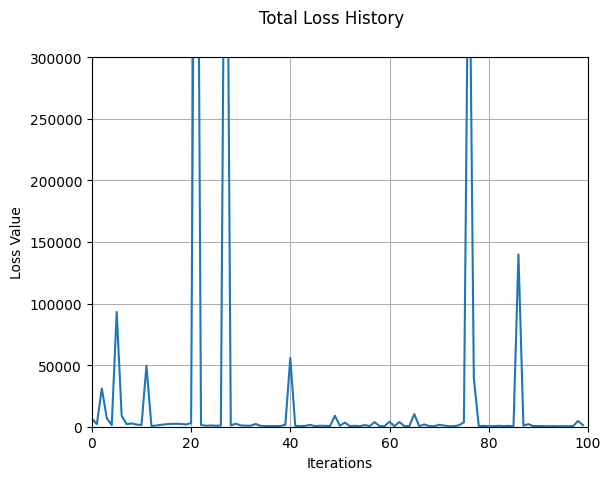

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:53,  1.75s/it, loss=6.35e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:04,  1.88s/it, loss=3.93e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:10,  1.97s/it, loss=2.47e+5]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:18,  2.07s/it, loss=7.24e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:33,  2.25s/it, loss=8.88e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:50,  2.46s/it, loss=7.19e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:02,  2.61s/it, loss=1.39e+4]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:12,  2.75s/it, loss=5.47e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:21,  2.87s/it, loss=6.09e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:25<04:33,  3.04s/it, loss=8.5e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:29<04:44,  3.19s/it, loss=3.35e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:33<04:56,  3.37s/it, loss=1.5e+4] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:09,  3.56s/it, loss=1.64e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:41<05:19,  3.72s/it, loss=4.58e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:45<05:30,  3.89s/it, loss=1.69e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:50<05:41,  4.07s/it, loss=1.58e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:54<05:55,  4.28s/it, loss=1.37e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [00:59<06:05,  4.46s/it, loss=1.57e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:04<06:19,  4.68s/it, loss=8.28e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:10<06:28,  4.86s/it, loss=5.81e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:15<06:38,  5.05s/it, loss=6.68e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:21<06:49,  5.25s/it, loss=5.04e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:27<06:56,  5.41s/it, loss=2.97e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:33<07:02,  5.57s/it, loss=3.84e+5]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:39<07:11,  5.75s/it, loss=2.49e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:45<07:19,  5.94s/it, loss=3.13e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:52<07:37,  6.26s/it, loss=8.37e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:59<07:38,  6.37s/it, loss=7.62e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:06<07:42,  6.51s/it, loss=3.76e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:13<07:46,  6.66s/it, loss=1.01e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:20<07:52,  6.84s/it, loss=1.34e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:28<08:04,  7.12s/it, loss=1.21e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:35<08:07,  7.27s/it, loss=1.5e+4] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:43<08:10,  7.43s/it, loss=1.9e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:51<08:15,  7.63s/it, loss=1.97e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [02:59<08:18,  7.80s/it, loss=3.11e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:08<08:20,  7.94s/it, loss=2.65e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:16<08:22,  8.11s/it, loss=2.8e+4] 


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:25<08:25,  8.29s/it, loss=3.54e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:34<08:30,  8.51s/it, loss=3.2e+4] 


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:43<08:31,  8.67s/it, loss=3.33e+4]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:52<08:32,  8.84s/it, loss=3.51e+4]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:02<08:33,  9.01s/it, loss=3.78e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:11<08:35,  9.21s/it, loss=3.44e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:21<08:35,  9.37s/it, loss=3.38e+4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:31<08:34,  9.53s/it, loss=3.32e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:42<08:42,  9.86s/it, loss=7.28e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:52<08:41, 10.03s/it, loss=3.21e+4]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:03<08:39, 10.18s/it, loss=3.15e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:13<08:35, 10.32s/it, loss=3.68e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:24<08:33, 10.47s/it, loss=3.27e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:35<08:32, 10.67s/it, loss=3.59e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:47<08:34, 10.94s/it, loss=3.65e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [05:58<08:29, 11.07s/it, loss=4.43e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:10<08:25, 11.24s/it, loss=4.11e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:22<08:22, 11.41s/it, loss=4.13e+4]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:34<08:20, 11.63s/it, loss=4.37e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:46<08:16, 11.83s/it, loss=4.34e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [06:58<08:11, 11.98s/it, loss=4.42e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:11<08:05, 12.13s/it, loss=4.43e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:23<07:59, 12.29s/it, loss=5.37e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:37<07:56, 12.53s/it, loss=4.25e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:50<07:52, 12.76s/it, loss=4.25e+4]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:04<07:49, 13.04s/it, loss=4.07e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:17<07:42, 13.21s/it, loss=3.97e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:31<07:35, 13.39s/it, loss=4.48e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:45<07:28, 13.59s/it, loss=3.49e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [08:59<07:23, 13.85s/it, loss=3.32e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:14<07:14, 14.00s/it, loss=2.98e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:28<07:05, 14.17s/it, loss=5.07e+4]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:43<06:55, 14.33s/it, loss=3.11e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [09:58<06:48, 14.58s/it, loss=3.3e+4] 


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:13<06:38, 14.74s/it, loss=3.98e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:29<06:26, 14.87s/it, loss=4.05e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:44<06:14, 14.98s/it, loss=4.56e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [10:59<06:04, 15.18s/it, loss=5.01e+4]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:15<05:53, 15.39s/it, loss=5.61e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:31<05:43, 15.61s/it, loss=5.96e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:48<05:31, 15.77s/it, loss=6.37e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:04<05:19, 15.95s/it, loss=6.65e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:21<05:07, 16.20s/it, loss=8.12e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:37<04:54, 16.36s/it, loss=7.18e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:54<04:41, 16.56s/it, loss=7.3e+4] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:12<04:27, 16.74s/it, loss=7.39e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:29<04:14, 16.94s/it, loss=7.49e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:46<03:58, 17.07s/it, loss=7.4e+4] 


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:04<03:43, 17.18s/it, loss=7.24e+4]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:22<03:27, 17.32s/it, loss=7.1e+4] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:40<03:13, 17.55s/it, loss=6.97e+4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [14:58<02:57, 17.71s/it, loss=6.68e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:16<02:40, 17.88s/it, loss=6.44e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:35<02:24, 18.11s/it, loss=6.25e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:53<02:07, 18.28s/it, loss=6.04e+4]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:12<01:50, 18.44s/it, loss=5.64e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:31<01:32, 18.57s/it, loss=6.59e+4]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:50<01:15, 18.81s/it, loss=5.17e+4]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:10<00:56, 18.95s/it, loss=4.82e+4]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:29<00:38, 19.16s/it, loss=4.55e+4]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:49<00:19, 19.35s/it, loss=4.32e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:09<00:00, 10.89s/it, loss=4.04e+4]


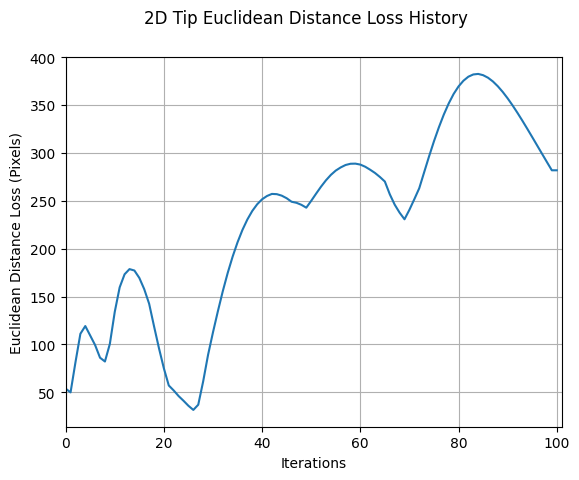

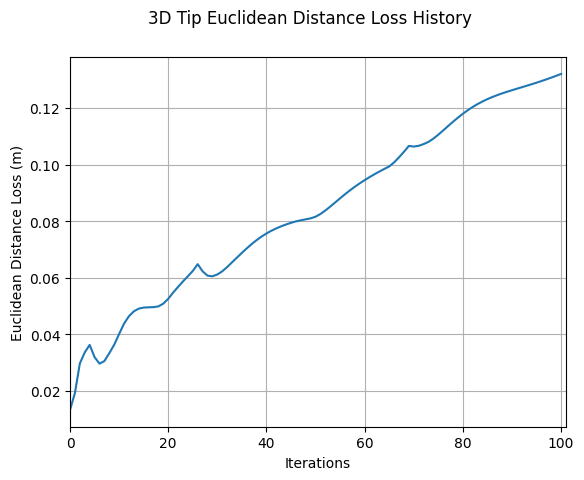

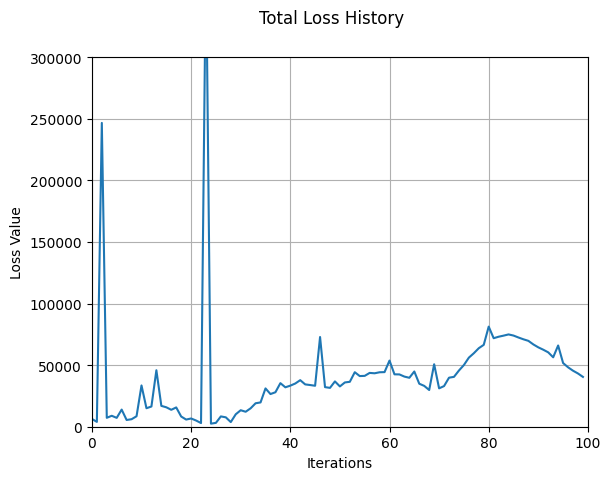

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:49,  1.71s/it, loss=4.69e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:04<03:27,  2.12s/it, loss=1.27e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:33,  2.20s/it, loss=1.51e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:37,  2.26s/it, loss=1.07e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:11<03:42,  2.34s/it, loss=3.02e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:51,  2.47s/it, loss=1.34e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:01,  2.59s/it, loss=672]    


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:13,  2.75s/it, loss=1.29e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:25,  2.92s/it, loss=1.05e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:38,  3.10s/it, loss=642]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:50,  3.26s/it, loss=490]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<04:58,  3.40s/it, loss=647]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:10,  3.57s/it, loss=2.05e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:26,  3.80s/it, loss=1.2e+3] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:39,  4.00s/it, loss=2.61e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:48,  4.15s/it, loss=546]    


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:00,  4.34s/it, loss=4e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:09,  4.51s/it, loss=446] 


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:19,  4.68s/it, loss=626]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:27,  4.84s/it, loss=797]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:38,  5.04s/it, loss=1.37e+5]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:45,  5.19s/it, loss=522]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<06:53,  5.37s/it, loss=2.05e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:00,  5.53s/it, loss=475]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:08,  5.71s/it, loss=465]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:46<07:19,  5.94s/it, loss=538]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:25,  6.10s/it, loss=545]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:59<07:31,  6.27s/it, loss=668]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:06<07:36,  6.43s/it, loss=465]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:13<07:46,  6.67s/it, loss=1.53e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:21<07:54,  6.88s/it, loss=457]    


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:28<08:04,  7.12s/it, loss=641]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:36<08:08,  7.29s/it, loss=565]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:44<08:12,  7.47s/it, loss=742]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:52<08:19,  7.68s/it, loss=488]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:00<08:20,  7.81s/it, loss=572]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:09<08:21,  7.96s/it, loss=474]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:17<08:24,  8.13s/it, loss=509]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:26<08:27,  8.32s/it, loss=1.05e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:35<08:30,  8.51s/it, loss=480]    


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:44<08:32,  8.68s/it, loss=447]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:53<08:33,  8.86s/it, loss=421]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:03<08:40,  9.13s/it, loss=5.11e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:13<08:43,  9.35s/it, loss=4.69e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:23<08:41,  9.49s/it, loss=1.04e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:33<08:40,  9.64s/it, loss=1.13e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:43<08:39,  9.80s/it, loss=6.57e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:53<08:38,  9.97s/it, loss=454]    


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:04<08:39, 10.19s/it, loss=2.62e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:15<08:39, 10.39s/it, loss=9.93e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:26<08:36, 10.54s/it, loss=1.4e+3] 


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:37<08:34, 10.71s/it, loss=939]   


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:48<08:33, 10.93s/it, loss=449]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [05:59<08:28, 11.05s/it, loss=589]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:11<08:28, 11.29s/it, loss=451]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:23<08:26, 11.50s/it, loss=417]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:36<08:26, 11.78s/it, loss=9.88e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:48<08:21, 11.95s/it, loss=442]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:00<08:15, 12.08s/it, loss=760]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:13<08:09, 12.23s/it, loss=461]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:26<08:06, 12.49s/it, loss=1.1e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:39<08:01, 12.68s/it, loss=417]   


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:53<07:56, 12.87s/it, loss=514]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:06<07:50, 13.07s/it, loss=756]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:20<07:43, 13.24s/it, loss=2.45e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:34<07:38, 13.49s/it, loss=1.26e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:48<07:30, 13.66s/it, loss=422]    


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:02<07:21, 13.81s/it, loss=440]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:16<07:13, 13.97s/it, loss=537]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:31<07:05, 14.19s/it, loss=450]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:46<06:58, 14.44s/it, loss=445]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:01<06:47, 14.55s/it, loss=507]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:16<06:36, 14.67s/it, loss=704]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:31<06:26, 14.86s/it, loss=562]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:47<06:17, 15.12s/it, loss=1.22e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:02<06:05, 15.25s/it, loss=685]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:18<05:54, 15.40s/it, loss=476]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:34<05:42, 15.58s/it, loss=521]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:51<05:33, 15.86s/it, loss=583]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:07<05:20, 16.02s/it, loss=470]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:24<05:07, 16.21s/it, loss=993]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:41<04:55, 16.39s/it, loss=453]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:58<04:42, 16.62s/it, loss=464]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:15<04:28, 16.76s/it, loss=5.46e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:32<04:13, 16.91s/it, loss=628]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:49<03:58, 17.07s/it, loss=1.35e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:07<03:44, 17.26s/it, loss=449]    


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:25<03:28, 17.38s/it, loss=443]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:43<03:13, 17.58s/it, loss=447]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:01<02:58, 17.83s/it, loss=534]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:20<02:41, 17.97s/it, loss=1.62e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:38<02:25, 18.13s/it, loss=550]    


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:57<02:07, 18.28s/it, loss=525]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:16<01:50, 18.48s/it, loss=748]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:35<01:33, 18.65s/it, loss=527]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:54<01:15, 18.98s/it, loss=461]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:14<00:57, 19.18s/it, loss=558]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:36<00:40, 20.08s/it, loss=434]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:57<00:20, 20.15s/it, loss=1.42e+5]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:17<00:00, 10.98s/it, loss=3.16e+3]


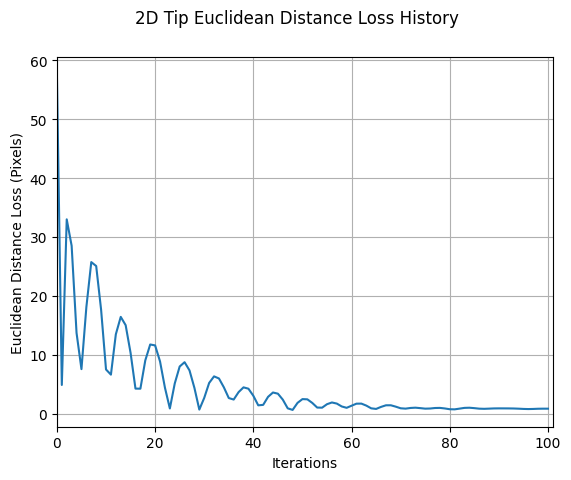

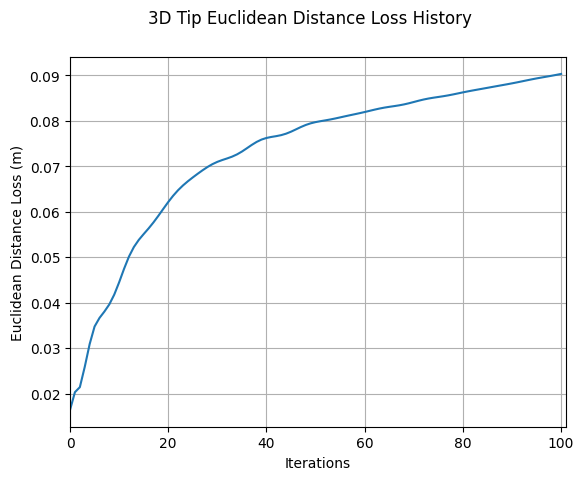

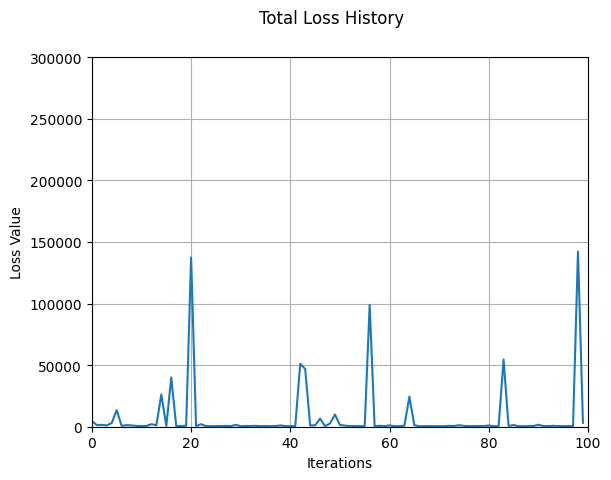

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:56,  1.78s/it, loss=6.78e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:05,  1.89s/it, loss=3.95e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:16,  2.03s/it, loss=1.59e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:25,  2.14s/it, loss=1.57e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:39,  2.31s/it, loss=2.04e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:56,  2.52s/it, loss=3.18e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:06,  2.65s/it, loss=1.76e+4]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:17,  2.80s/it, loss=1.77e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:28,  2.95s/it, loss=1.24e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:39,  3.10s/it, loss=981]   


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:01,  3.38s/it, loss=1.13e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:08,  3.50s/it, loss=2e+4]   


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:16,  3.64s/it, loss=832] 


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:24,  3.77s/it, loss=1.08e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:32,  3.91s/it, loss=1.34e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:43,  4.09s/it, loss=1.1e+3] 


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<05:53,  4.26s/it, loss=914]   


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:09,  4.51s/it, loss=3.25e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:05<06:17,  4.67s/it, loss=879]    


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:28,  4.85s/it, loss=460]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:35,  5.01s/it, loss=726]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:45,  5.20s/it, loss=859]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:27<06:52,  5.36s/it, loss=1.61e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:33<07:02,  5.56s/it, loss=769]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:08,  5.71s/it, loss=704]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:46<07:20,  5.95s/it, loss=637]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:26,  6.12s/it, loss=1.17e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:59<07:32,  6.28s/it, loss=1.22e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:06<07:43,  6.53s/it, loss=529]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:13<07:48,  6.70s/it, loss=514]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:21<07:54,  6.88s/it, loss=531]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:28<07:59,  7.05s/it, loss=487]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:36<08:05,  7.24s/it, loss=647]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:44<08:10,  7.43s/it, loss=425]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:52<08:13,  7.59s/it, loss=439]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:00<08:16,  7.76s/it, loss=406]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:08<08:19,  7.93s/it, loss=2.4e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:17<08:25,  8.15s/it, loss=359]   


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:26<08:28,  8.33s/it, loss=362]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:34<08:30,  8.50s/it, loss=826]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:44<08:34,  8.72s/it, loss=377]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:53<08:34,  8.88s/it, loss=700]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:02<08:36,  9.07s/it, loss=612]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:12<08:38,  9.26s/it, loss=371]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:22<08:42,  9.50s/it, loss=497]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:32<08:45,  9.72s/it, loss=471]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:43<08:42,  9.85s/it, loss=341]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:53<08:40, 10.01s/it, loss=1.06e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:04<08:39, 10.18s/it, loss=962]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:14<08:38, 10.37s/it, loss=351]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:26<08:39, 10.60s/it, loss=801]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:37<08:36, 10.77s/it, loss=772]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:48<08:34, 10.95s/it, loss=4.1e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:00<08:30, 11.11s/it, loss=340]   


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:11<08:26, 11.26s/it, loss=7.72e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:23<08:24, 11.46s/it, loss=1.35e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:35<08:22, 11.69s/it, loss=534]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:47<08:16, 11.82s/it, loss=3.53e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:00<08:10, 11.97s/it, loss=2.62e+3]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:12<08:06, 12.15s/it, loss=501]    


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:25<08:01, 12.36s/it, loss=764]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:38<08:00, 12.64s/it, loss=1.24e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:52<07:53, 12.81s/it, loss=3.37e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:05<07:47, 12.98s/it, loss=379]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:19<07:42, 13.20s/it, loss=609]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:33<07:34, 13.37s/it, loss=766]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:47<07:29, 13.62s/it, loss=977]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:01<07:21, 13.80s/it, loss=1.23e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:15<07:13, 13.98s/it, loss=985]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:30<07:03, 14.13s/it, loss=656]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:45<06:57, 14.38s/it, loss=8.55e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:00<06:47, 14.56s/it, loss=697]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:15<06:36, 14.70s/it, loss=4.65e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:30<06:25, 14.84s/it, loss=633]    


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:45<06:14, 14.98s/it, loss=5.48e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:01<06:05, 15.22s/it, loss=749]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:17<05:54, 15.39s/it, loss=563]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:33<05:42, 15.57s/it, loss=3.32e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:49<05:29, 15.68s/it, loss=2.7e+4] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:05<05:18, 15.93s/it, loss=588]   


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:22<05:05, 16.07s/it, loss=1.51e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:38<04:52, 16.23s/it, loss=362]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:55<04:39, 16.41s/it, loss=886]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:12<04:27, 16.69s/it, loss=710]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:30<04:12, 16.83s/it, loss=1.15e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:47<03:57, 16.98s/it, loss=940]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:05<03:43, 17.17s/it, loss=1.06e+6]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:23<03:28, 17.40s/it, loss=5.68e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:40<03:13, 17.56s/it, loss=1.35e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [14:59<02:57, 17.71s/it, loss=694]    


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:17<02:41, 17.94s/it, loss=327]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:36<02:25, 18.13s/it, loss=718]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:54<02:07, 18.27s/it, loss=560]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:13<01:50, 18.42s/it, loss=324]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:32<01:33, 18.68s/it, loss=326]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:51<01:15, 18.82s/it, loss=329]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:11<00:56, 18.96s/it, loss=517]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:30<00:38, 19.20s/it, loss=328]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:50<00:19, 19.34s/it, loss=354]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:10<00:00, 10.90s/it, loss=322]


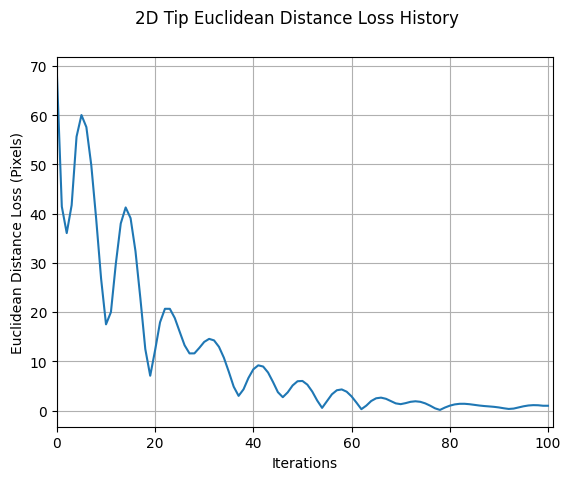

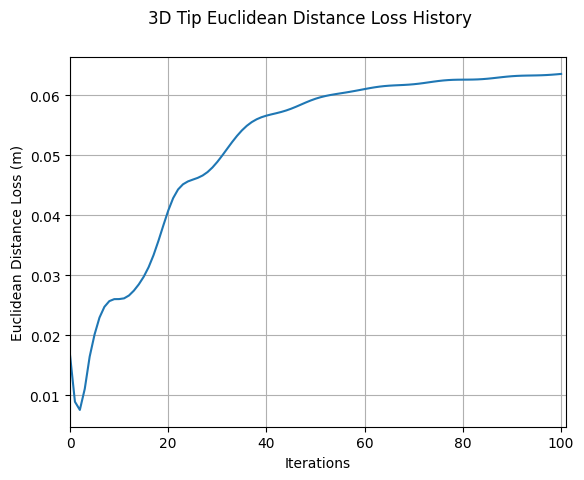

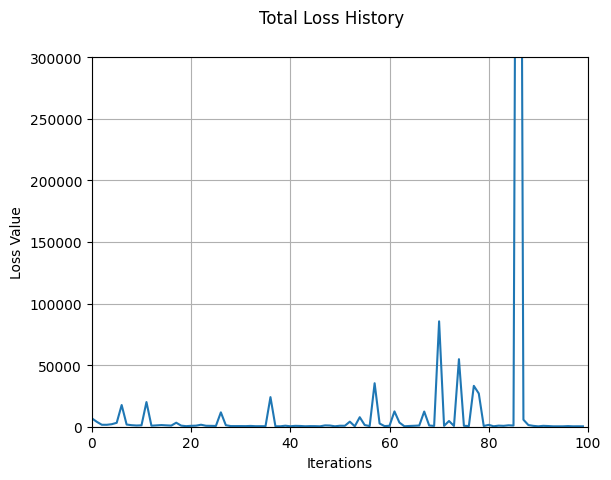

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:02<03:45,  2.28s/it, loss=4.32e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:04<03:17,  2.02s/it, loss=1.71e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:24,  2.10s/it, loss=934]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:29,  2.19s/it, loss=6.19e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:11<03:42,  2.35s/it, loss=3.9e+3] 


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:52,  2.48s/it, loss=4.76e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:05,  2.64s/it, loss=8.58e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:18,  2.82s/it, loss=1.97e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:33,  3.01s/it, loss=1.16e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:46,  3.18s/it, loss=1.3e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:55,  3.33s/it, loss=9.4e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:05,  3.48s/it, loss=8.63e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:16,  3.64s/it, loss=7.29e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:27,  3.81s/it, loss=6.89e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:42,  4.03s/it, loss=2.73e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:52<05:53,  4.21s/it, loss=2.91e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:04,  4.39s/it, loss=3.54e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:13,  4.56s/it, loss=614]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:24,  4.74s/it, loss=1.33e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:32,  4.91s/it, loss=1.15e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:38,  5.04s/it, loss=1.77e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:46,  5.21s/it, loss=2.55e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<07:02,  5.48s/it, loss=3.63e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:08,  5.64s/it, loss=2.02e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:15,  5.80s/it, loss=5.64e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:21,  5.96s/it, loss=6.62e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:26,  6.11s/it, loss=7.82e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:33,  6.30s/it, loss=1.2e+4] 


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:39,  6.48s/it, loss=9.88e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:50,  6.73s/it, loss=1.12e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<08:01,  6.98s/it, loss=1.34e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:30<08:06,  7.16s/it, loss=1.72e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:38<08:14,  7.38s/it, loss=2.23e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:46<08:17,  7.54s/it, loss=1.4e+4] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:54<08:19,  7.69s/it, loss=1.44e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:22,  7.86s/it, loss=1.74e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:23,  8.00s/it, loss=1.6e+4] 


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:27,  8.18s/it, loss=1.5e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:31,  8.38s/it, loss=1.95e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:33,  8.56s/it, loss=1.56e+4]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:37,  8.77s/it, loss=1.59e+4]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:37,  8.92s/it, loss=1.9e+4] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:37,  9.08s/it, loss=1.67e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:38,  9.25s/it, loss=1.8e+4] 


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:39,  9.45s/it, loss=3.68e+4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:40,  9.64s/it, loss=1.75e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:42,  9.86s/it, loss=1.65e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:43, 10.06s/it, loss=1.61e+4]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:42, 10.24s/it, loss=1.59e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:42, 10.45s/it, loss=1.7e+4] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:40, 10.62s/it, loss=1.89e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:41, 10.86s/it, loss=1.54e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:51<08:42, 11.11s/it, loss=1.57e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:03<08:38, 11.28s/it, loss=1.58e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:33, 11.41s/it, loss=1.53e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:26, 11.51s/it, loss=1.59e+4]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:21, 11.66s/it, loss=1.56e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:50<08:16, 11.83s/it, loss=1.63e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:04<08:30, 12.45s/it, loss=1.66e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:17<08:18, 12.47s/it, loss=8.05e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:30<08:09, 12.55s/it, loss=1.43e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:43<08:05, 12.77s/it, loss=1.44e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:56<07:59, 12.95s/it, loss=1.61e+4]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:10<07:55, 13.21s/it, loss=1.45e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:24<07:47, 13.34s/it, loss=1.4e+4] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:37<07:38, 13.48s/it, loss=3.28e+6]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:51<07:30, 13.65s/it, loss=1.38e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:06<07:22, 13.84s/it, loss=1.37e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:15, 14.05s/it, loss=3.4e+4] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:35<07:05, 14.20s/it, loss=1.35e+4]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:50<06:56, 14.35s/it, loss=1.35e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:48, 14.59s/it, loss=1.33e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:40, 14.83s/it, loss=1.57e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:35<06:29, 14.98s/it, loss=1.33e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:18, 15.15s/it, loss=1.32e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:06, 15.28s/it, loss=1.34e+4]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:56, 15.48s/it, loss=1.34e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:45, 15.72s/it, loss=1.33e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:32, 15.83s/it, loss=1.32e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:11<05:20, 16.00s/it, loss=1.31e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:08, 16.22s/it, loss=1.45e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:54, 16.36s/it, loss=1.33e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:41, 16.53s/it, loss=1.3e+4] 


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:27, 16.69s/it, loss=5.48e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:36<04:13, 16.90s/it, loss=1.63e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:53<03:58, 17.05s/it, loss=1.41e+4]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:11<03:43, 17.23s/it, loss=1.47e+4]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:29<03:28, 17.38s/it, loss=1.42e+4]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:47<03:13, 17.63s/it, loss=1.29e+4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:05<02:58, 17.82s/it, loss=1.29e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:24<02:42, 18.04s/it, loss=1.31e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:42<02:25, 18.21s/it, loss=1.29e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:01<02:08, 18.38s/it, loss=1.3e+4] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:20<01:51, 18.51s/it, loss=1.48e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:39<01:33, 18.64s/it, loss=1.31e+4]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:58<01:15, 18.86s/it, loss=1.42e+4]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:18<00:57, 19.04s/it, loss=8.23e+4]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:37<00:38, 19.18s/it, loss=1.28e+4]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:57<00:19, 19.43s/it, loss=3.35e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:17<00:00, 10.98s/it, loss=1.6e+4]


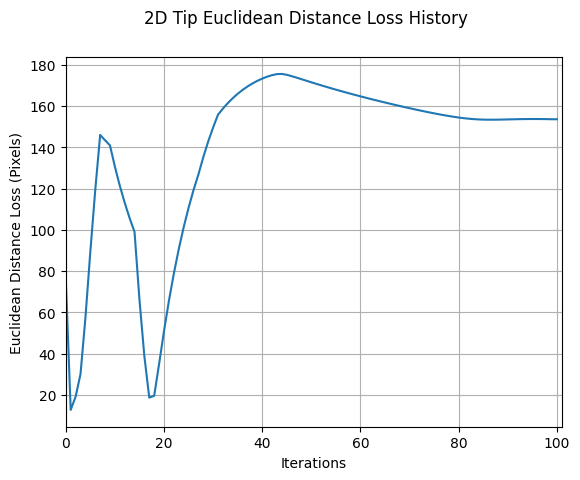

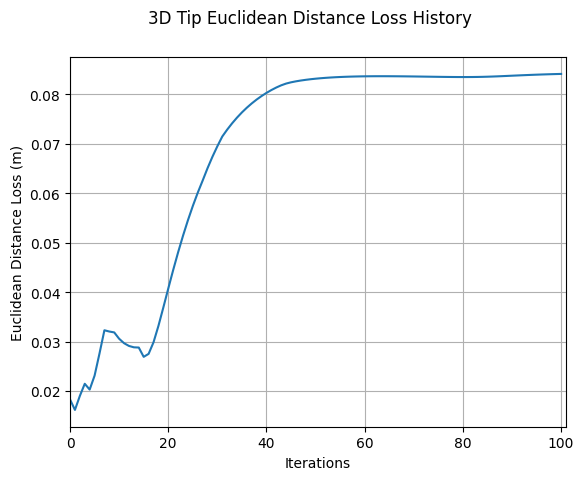

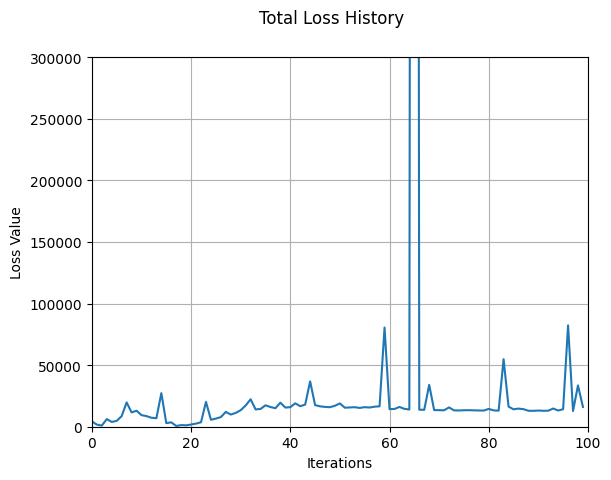

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:54,  1.76s/it, loss=2.05e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:02,  1.86s/it, loss=4.04e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:15,  2.02s/it, loss=1.43e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:25,  2.14s/it, loss=2.14e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:39,  2.31s/it, loss=3.82e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:49,  2.44s/it, loss=3.74e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:02,  2.61s/it, loss=4.95e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:15,  2.77s/it, loss=2.02e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:26,  2.93s/it, loss=6.88e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:54,  3.27s/it, loss=7.04e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:02,  3.40s/it, loss=4.29e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:09,  3.51s/it, loss=1.73e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:19,  3.68s/it, loss=1.88e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:31,  3.85s/it, loss=2.9e+4] 


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:38,  3.98s/it, loss=3.29e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:48,  4.15s/it, loss=4.19e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:00,  4.34s/it, loss=4.94e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:08,  4.49s/it, loss=5.89e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:16,  4.65s/it, loss=6.7e+4] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:27,  4.84s/it, loss=7.57e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:34,  4.99s/it, loss=8.5e+4] 


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:43,  5.17s/it, loss=9.41e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<06:52,  5.35s/it, loss=1.01e+5]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:00,  5.53s/it, loss=1.09e+5]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:07,  5.71s/it, loss=1.17e+5]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:27,  6.04s/it, loss=1.27e+5]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:31,  6.18s/it, loss=1.32e+5]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:35,  6.33s/it, loss=1.38e+5]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:41,  6.50s/it, loss=1.44e+5]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:47,  6.67s/it, loss=1.5e+5] 


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:21<07:54,  6.88s/it, loss=1.55e+5]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<07:59,  7.05s/it, loss=1.6e+5] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:36<08:02,  7.20s/it, loss=1.65e+5]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:44<08:07,  7.39s/it, loss=1.69e+5]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:52<08:16,  7.63s/it, loss=1.73e+5]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:00<08:21,  7.84s/it, loss=1.76e+5]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:09<08:25,  8.02s/it, loss=1.79e+5]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:17<08:25,  8.15s/it, loss=1.96e+5]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:26<08:28,  8.34s/it, loss=1.85e+5]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:35<08:31,  8.53s/it, loss=1.87e+5]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:44<08:33,  8.71s/it, loss=1.89e+5]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:53<08:34,  8.88s/it, loss=1.9e+5] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:03<08:40,  9.13s/it, loss=1.92e+5]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:13<08:40,  9.29s/it, loss=2e+5]   


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:23<08:43,  9.51s/it, loss=1.98e+5]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:33<08:43,  9.69s/it, loss=1.96e+5]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:43<08:40,  9.82s/it, loss=1.95e+5]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:53<08:39,  9.98s/it, loss=1.96e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:04<08:41, 10.22s/it, loss=1.95e+5]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:15<08:38, 10.37s/it, loss=1.95e+5]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:26<08:36, 10.53s/it, loss=1.95e+5]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:37<08:33, 10.70s/it, loss=1.94e+5]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:48<08:31, 10.87s/it, loss=1.95e+5]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:00<08:27, 11.04s/it, loss=1.93e+5]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:11<08:26, 11.26s/it, loss=1.93e+5]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:23<08:21, 11.40s/it, loss=1.92e+5]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:35<08:18, 11.59s/it, loss=1.93e+5]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:48<08:20, 11.91s/it, loss=1.91e+5]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:00<08:13, 12.04s/it, loss=1.9e+5] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:13<08:08, 12.21s/it, loss=1.91e+5]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:26<08:04, 12.41s/it, loss=1.88e+5]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:39<07:59, 12.61s/it, loss=1.88e+5]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:52<07:53, 12.80s/it, loss=1.91e+5]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:05<07:46, 12.97s/it, loss=1.85e+5]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:19<07:39, 13.13s/it, loss=1.95e+5]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:33<07:34, 13.38s/it, loss=1.84e+5]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:47<07:25, 13.51s/it, loss=1.83e+5]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:01<07:18, 13.72s/it, loss=1.81e+5]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:15<07:13, 13.97s/it, loss=1.9e+5] 


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:30<07:07, 14.24s/it, loss=1.8e+5]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:45<06:56, 14.37s/it, loss=1.78e+5]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:00<06:45, 14.49s/it, loss=1.78e+5]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:15<06:34, 14.62s/it, loss=1.76e+5]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:30<06:24, 14.78s/it, loss=1.75e+5]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:45<06:15, 15.03s/it, loss=1.77e+5]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:01<06:04, 15.20s/it, loss=1.73e+5]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:17<05:53, 15.35s/it, loss=3.69e+5]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:33<05:41, 15.53s/it, loss=1.71e+5]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:49<05:31, 15.76s/it, loss=1.7e+5] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:05<05:18, 15.95s/it, loss=1.69e+5]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:22<05:05, 16.08s/it, loss=1.68e+5]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:38<04:52, 16.27s/it, loss=1.67e+5]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:56<04:40, 16.53s/it, loss=1.69e+5]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:13<04:26, 16.67s/it, loss=1.64e+5]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:30<04:12, 16.81s/it, loss=1.63e+5]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:47<03:57, 16.96s/it, loss=1.63e+5]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:05<03:43, 17.17s/it, loss=1.61e+5]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:22<03:27, 17.33s/it, loss=1.6e+5] 


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:40<03:12, 17.51s/it, loss=1.59e+5]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [14:59<02:57, 17.77s/it, loss=1.58e+5]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:17<02:41, 17.96s/it, loss=1.58e+5]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:36<02:25, 18.13s/it, loss=1.56e+5]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:54<02:07, 18.25s/it, loss=1.55e+5]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:13<01:51, 18.52s/it, loss=1.57e+5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:32<01:33, 18.66s/it, loss=1.57e+5]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:52<01:15, 18.83s/it, loss=1.52e+5]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:11<00:57, 19.08s/it, loss=1.51e+5]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:31<00:38, 19.25s/it, loss=1.5e+5] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:51<00:19, 19.52s/it, loss=1.49e+5]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:11<00:00, 10.91s/it, loss=1.48e+5]


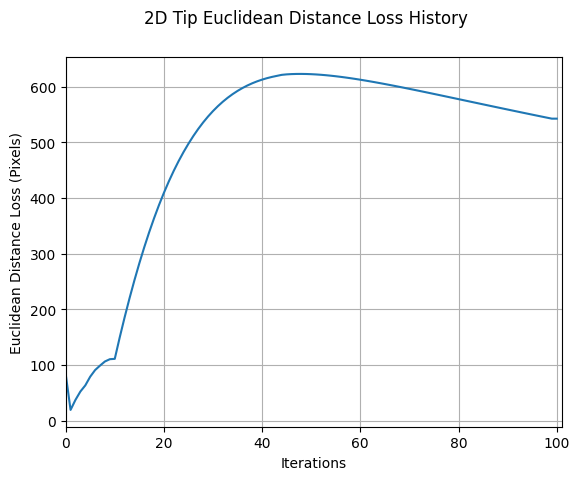

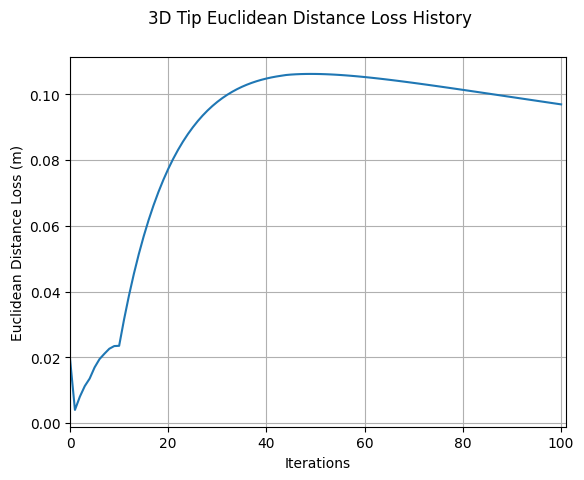

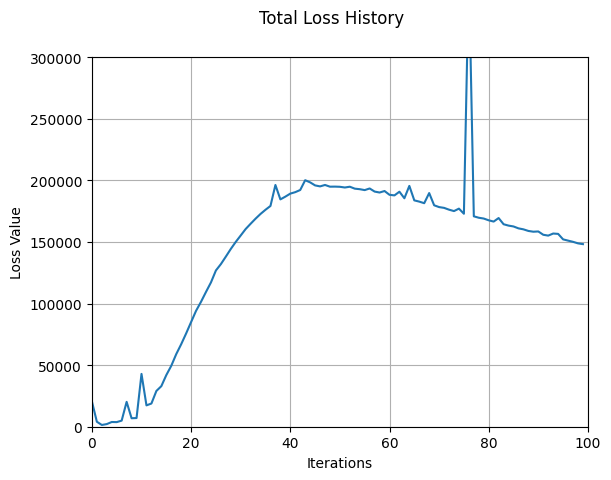

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:54,  1.76s/it, loss=5.85e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:05,  1.89s/it, loss=725]    


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:17,  2.04s/it, loss=1.38e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:26,  2.15s/it, loss=3.03e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:42,  2.34s/it, loss=4.47e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:54,  2.49s/it, loss=6.32e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:06,  2.65s/it, loss=7.66e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:18,  2.81s/it, loss=9.7e+3] 


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:29,  2.97s/it, loss=1.17e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:38,  3.10s/it, loss=1.6e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:51,  3.27s/it, loss=1.58e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:02,  3.44s/it, loss=1.7e+4] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:20,  3.68s/it, loss=2.19e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:31,  3.86s/it, loss=2.27e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:40,  4.00s/it, loss=2.75e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:49,  4.16s/it, loss=3.08e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:01,  4.36s/it, loss=2.84e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:12,  4.55s/it, loss=2.91e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:28,  4.80s/it, loss=2.94e+4]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:36,  4.95s/it, loss=2.96e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:44,  5.12s/it, loss=2.94e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:51,  5.28s/it, loss=2.89e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<07:00,  5.46s/it, loss=2.93e+4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:07,  5.62s/it, loss=2.72e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:15,  5.80s/it, loss=2.6e+4] 


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:22,  5.98s/it, loss=2.43e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:28,  6.15s/it, loss=2.42e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:34,  6.31s/it, loss=2.16e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:40,  6.49s/it, loss=2.01e+4]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:51,  6.74s/it, loss=1.87e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<07:57,  6.92s/it, loss=1.74e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:03,  7.11s/it, loss=1.61e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:08,  7.29s/it, loss=1.48e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:13,  7.48s/it, loss=1.35e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:16,  7.64s/it, loss=1.24e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:30,  7.97s/it, loss=1.58e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:30,  8.10s/it, loss=1.16e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:36,  8.33s/it, loss=1.05e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:35,  8.45s/it, loss=2.33e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:37,  8.62s/it, loss=7.92e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:39,  8.81s/it, loss=8.58e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:39,  8.95s/it, loss=7.16e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:39,  9.11s/it, loss=7.11e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:15<08:40,  9.29s/it, loss=7.05e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:25<08:44,  9.53s/it, loss=7.06e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:35<08:43,  9.69s/it, loss=6.84e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:41,  9.84s/it, loss=6.42e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:41, 10.03s/it, loss=6.2e+3] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:40, 10.20s/it, loss=7.58e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:39, 10.38s/it, loss=6.18e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:37, 10.57s/it, loss=5.93e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:37, 10.78s/it, loss=5.7e+3] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:50<08:34, 10.95s/it, loss=5.33e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:02<08:31, 11.11s/it, loss=5.07e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:29, 11.32s/it, loss=4.42e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:26, 11.52s/it, loss=4.29e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:27, 11.81s/it, loss=4.33e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:50<08:22, 11.96s/it, loss=4.8e+3] 


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:15, 12.10s/it, loss=2.26e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:15<08:08, 12.22s/it, loss=4.4e+3] 


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:28<08:02, 12.38s/it, loss=3.68e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:41<08:01, 12.66s/it, loss=3.83e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:55<07:56, 12.87s/it, loss=3.63e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:08<07:50, 13.08s/it, loss=3.75e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:22<07:42, 13.22s/it, loss=3.63e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:36<07:35, 13.39s/it, loss=3.87e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:50<07:30, 13.64s/it, loss=3.31e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:04<07:21, 13.79s/it, loss=1.98e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:19<07:13, 13.98s/it, loss=3.04e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:33<07:03, 14.12s/it, loss=3.47e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:48<06:54, 14.29s/it, loss=3.55e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:03<06:47, 14.55s/it, loss=2.88e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:18<06:36, 14.67s/it, loss=3.24e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:33<06:25, 14.81s/it, loss=3.05e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:48<06:14, 14.97s/it, loss=2.73e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:04<06:05, 15.22s/it, loss=2.63e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:20<05:53, 15.38s/it, loss=2.65e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:36<05:41, 15.54s/it, loss=4.51e+3]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:52<05:32, 15.83s/it, loss=2.44e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:09<05:24, 16.22s/it, loss=2.9e+3] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:26<05:10, 16.33s/it, loss=2.4e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:43<04:55, 16.41s/it, loss=2.4e+3]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:59<04:41, 16.54s/it, loss=2.32e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:17<04:29, 16.86s/it, loss=7.63e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:34<04:14, 16.99s/it, loss=2.3e+3] 


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:52<04:00, 17.14s/it, loss=9.4e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:09<03:44, 17.26s/it, loss=2.09e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:27<03:29, 17.46s/it, loss=2.09e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:45<03:13, 17.60s/it, loss=2.16e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:03<02:57, 17.75s/it, loss=4.38e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:22<02:41, 17.97s/it, loss=1.88e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:40<02:25, 18.13s/it, loss=2.21e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:59<02:08, 18.31s/it, loss=1.92e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:18<01:51, 18.54s/it, loss=1.84e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:37<01:33, 18.78s/it, loss=1.72e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:57<01:15, 18.93s/it, loss=1.69e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:16<00:57, 19.07s/it, loss=1.68e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:36<00:38, 19.33s/it, loss=1.79e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:56<00:19, 19.51s/it, loss=5.37e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:16<00:00, 10.97s/it, loss=1.83e+3]


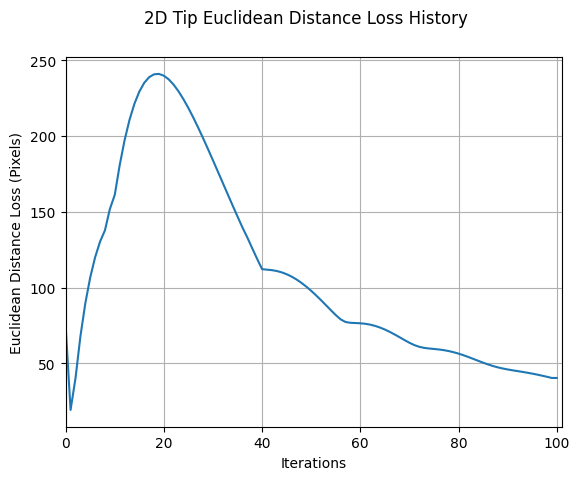

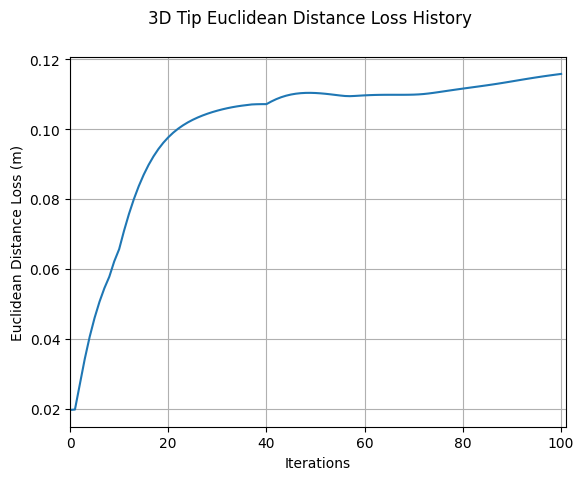

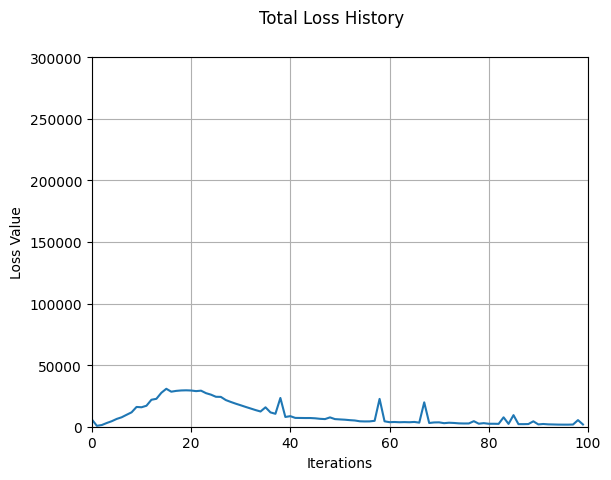

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:52,  1.74s/it, loss=5.06e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<02:59,  1.84s/it, loss=4.48e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:10,  1.97s/it, loss=3.57e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:20,  2.08s/it, loss=6.65e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:34,  2.26s/it, loss=1.1e+4] 


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:45,  2.40s/it, loss=1.41e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<03:58,  2.56s/it, loss=1.64e+4]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:15,  2.78s/it, loss=1.86e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:28,  2.95s/it, loss=2.17e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:39,  3.11s/it, loss=2.38e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:29<04:53,  3.29s/it, loss=2.75e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:33<05:01,  3.42s/it, loss=2.7e+4] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:11,  3.58s/it, loss=2.8e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:41<05:21,  3.74s/it, loss=2.93e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:45<05:32,  3.91s/it, loss=3.03e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:50<05:44,  4.10s/it, loss=3.05e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<05:56,  4.30s/it, loss=3.1e+4] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:17,  4.60s/it, loss=3.14e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:05<06:22,  4.72s/it, loss=3.13e+4]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:10<06:29,  4.87s/it, loss=3.14e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:38,  5.04s/it, loss=3.76e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:21<06:46,  5.21s/it, loss=3.13e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:27<06:57,  5.42s/it, loss=3.05e+4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:33<07:04,  5.58s/it, loss=3.01e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:39<07:10,  5.74s/it, loss=2.96e+4]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:46<07:17,  5.91s/it, loss=2.98e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:52<07:23,  6.08s/it, loss=2.85e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:59<07:31,  6.27s/it, loss=3.13e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:06<07:35,  6.42s/it, loss=2.71e+4]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:13<07:41,  6.59s/it, loss=2.65e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:20<07:50,  6.82s/it, loss=2.65e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:27<07:58,  7.03s/it, loss=2.57e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:35<08:09,  7.31s/it, loss=2.46e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:43<08:14,  7.49s/it, loss=2.4e+4] 


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:52<08:21,  7.71s/it, loss=2.35e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:00<08:22,  7.85s/it, loss=2.26e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:08<08:26,  8.04s/it, loss=2.25e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:17<08:28,  8.20s/it, loss=2.15e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:26<08:31,  8.39s/it, loss=2.13e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:35<08:34,  8.58s/it, loss=2.29e+4]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:44<08:38,  8.79s/it, loss=2e+4]   


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:53<08:38,  8.95s/it, loss=2.07e+4]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:03<08:40,  9.13s/it, loss=1.98e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:12<08:40,  9.29s/it, loss=1.92e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:22<08:39,  9.44s/it, loss=1.91e+4]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:32<08:40,  9.63s/it, loss=1.89e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:43<08:44,  9.89s/it, loss=2.06e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:53<08:44, 10.10s/it, loss=4.51e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:04<08:42, 10.25s/it, loss=1.85e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:15<08:41, 10.44s/it, loss=1.83e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:26<08:39, 10.60s/it, loss=1.77e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:37<08:38, 10.80s/it, loss=4.62e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:49<08:37, 11.02s/it, loss=1.7e+4] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:00<08:34, 11.18s/it, loss=1.68e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:12<08:35, 11.45s/it, loss=1.67e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:24<08:28, 11.55s/it, loss=1.6e+4] 


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:36<08:26, 11.77s/it, loss=1.59e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:49<08:19, 11.89s/it, loss=4.27e+5]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:01<08:16, 12.11s/it, loss=1.55e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:14<08:08, 12.22s/it, loss=1.53e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:26<08:03, 12.39s/it, loss=1.49e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:39<07:58, 12.59s/it, loss=1.47e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:53<07:53, 12.81s/it, loss=1.45e+4]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:06<07:50, 13.06s/it, loss=1.47e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:20<07:42, 13.22s/it, loss=1.4e+4] 


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:34<07:38, 13.48s/it, loss=1.49e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:48<07:29, 13.61s/it, loss=1.4e+4] 


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:03<07:25, 13.91s/it, loss=1.34e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:18<07:20, 14.21s/it, loss=2.32e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:33<07:13, 14.45s/it, loss=1.31e+4]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:48<07:05, 14.67s/it, loss=1.3e+4] 


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:03<06:53, 14.76s/it, loss=1.27e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:18<06:42, 14.92s/it, loss=1.23e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:33<06:31, 15.04s/it, loss=1.37e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:49<06:19, 15.18s/it, loss=1.54e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:05<06:07, 15.32s/it, loss=1.17e+4]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:20<05:56, 15.50s/it, loss=1.15e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:36<05:43, 15.63s/it, loss=1.15e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:52<05:31, 15.77s/it, loss=1.95e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:09<05:18, 15.93s/it, loss=1.16e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:26<05:07, 16.19s/it, loss=1.13e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:42<04:54, 16.35s/it, loss=1.08e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:59<04:41, 16.54s/it, loss=1.06e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:17<04:28, 16.81s/it, loss=1.03e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:34<04:15, 17.01s/it, loss=1.02e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:52<04:00, 17.15s/it, loss=9.97e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:09<03:44, 17.27s/it, loss=9.88e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:27<03:28, 17.41s/it, loss=9.61e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:45<03:14, 17.66s/it, loss=9.46e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:04<02:58, 17.87s/it, loss=9.24e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:22<02:42, 18.01s/it, loss=1.63e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:41<02:25, 18.21s/it, loss=1.12e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:59<02:08, 18.35s/it, loss=9.16e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:18<01:50, 18.49s/it, loss=8.67e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:37<01:33, 18.67s/it, loss=8.64e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:57<01:15, 18.90s/it, loss=9.1e+3] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:16<00:57, 19.00s/it, loss=2.29e+4]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:36<00:38, 19.24s/it, loss=8.12e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:56<00:19, 19.49s/it, loss=7.89e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:16<00:00, 10.96s/it, loss=7.92e+3]


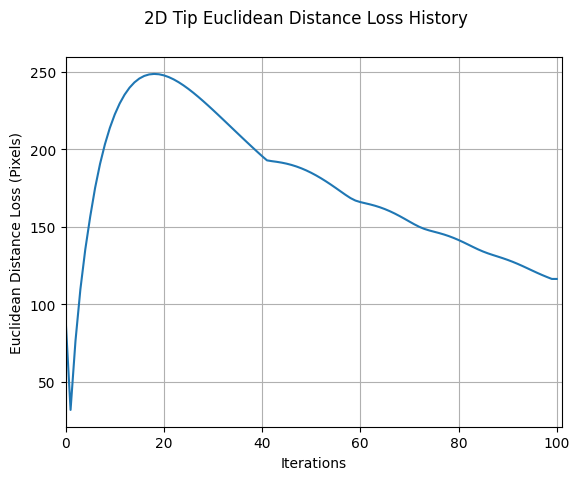

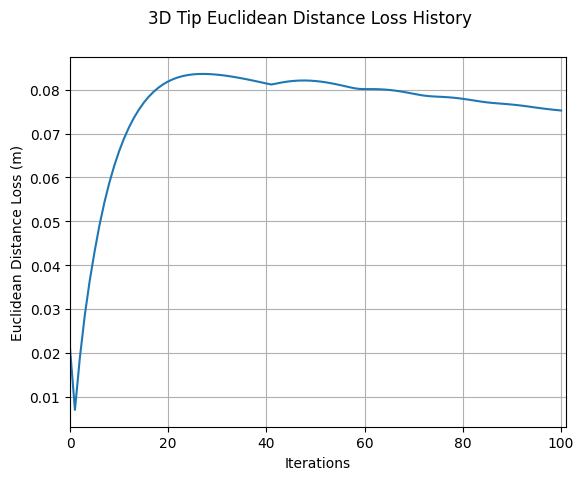

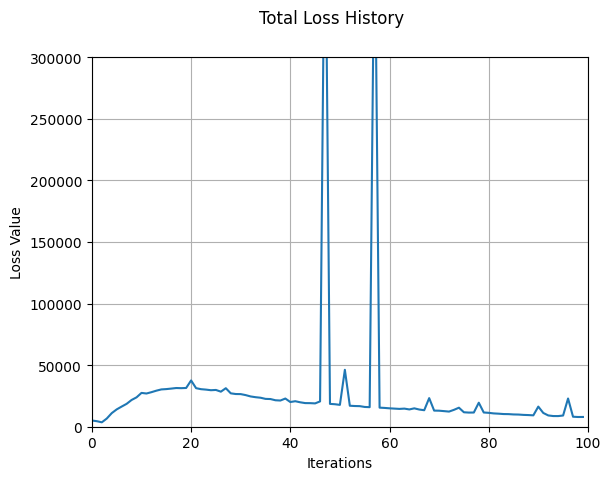

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:53,  1.76s/it, loss=4.41e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:01,  1.85s/it, loss=4.1e+4] 


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:13,  1.99s/it, loss=2.94e+4]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:21,  2.10s/it, loss=2.23e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:34,  2.25s/it, loss=2.91e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:48,  2.43s/it, loss=4.43e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:01,  2.59s/it, loss=6.01e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:12,  2.75s/it, loss=9.05e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:18,  2.84s/it, loss=9.2e+3] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:25<04:32,  3.02s/it, loss=1.17e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:29<04:45,  3.21s/it, loss=1.46e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:33<04:57,  3.38s/it, loss=1.53e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:12,  3.59s/it, loss=1.7e+4] 


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:41<05:25,  3.79s/it, loss=1.91e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:45<05:33,  3.93s/it, loss=3.19e+6]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:50<05:45,  4.11s/it, loss=1.05e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<06:07,  4.43s/it, loss=8.8e+3] 


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:13,  4.55s/it, loss=6.98e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:05<06:18,  4.67s/it, loss=5.4e+3] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:10<06:26,  4.83s/it, loss=2.32e+5]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:15<06:35,  5.00s/it, loss=2.5e+4] 


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:21<06:43,  5.18s/it, loss=2.41e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:27<06:50,  5.34s/it, loss=1.86e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:33<06:58,  5.50s/it, loss=1.8e+3] 


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:39<07:05,  5.67s/it, loss=1.62e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:45<07:18,  5.93s/it, loss=2.32e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:52<07:24,  6.09s/it, loss=3.12e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:58<07:30,  6.26s/it, loss=1.11e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:05<07:37,  6.44s/it, loss=7.55e+5]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:12<07:43,  6.62s/it, loss=1.11e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:19<07:49,  6.80s/it, loss=3.28e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:27<07:55,  6.99s/it, loss=2.5e+3] 


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:34<08:00,  7.17s/it, loss=1.83e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:42<08:09,  7.42s/it, loss=1.91e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:51<08:14,  7.62s/it, loss=2.5e+3] 


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [02:59<08:24,  7.88s/it, loss=1.26e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:07<08:24,  8.00s/it, loss=5.98e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:16<08:26,  8.17s/it, loss=2.01e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:25<08:27,  8.32s/it, loss=4.73e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:33<08:29,  8.49s/it, loss=1.38e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:42<08:28,  8.62s/it, loss=7.19e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:52<08:30,  8.80s/it, loss=6.3e+3] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:01<08:37,  9.08s/it, loss=7.98e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:11<08:37,  9.23s/it, loss=8.5e+3] 


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:21<08:37,  9.40s/it, loss=806]   


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:31<08:38,  9.60s/it, loss=1.62e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:41<08:37,  9.77s/it, loss=2.66e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:51<08:38,  9.96s/it, loss=1.45e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:02<08:37, 10.15s/it, loss=4.47e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:13<08:38, 10.37s/it, loss=2.17e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:24<08:35, 10.52s/it, loss=3.12e+5]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:35<08:32, 10.69s/it, loss=5.1e+5] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:46<08:29, 10.84s/it, loss=8.3e+5]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [05:57<08:25, 10.98s/it, loss=1.11e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:09<08:24, 11.20s/it, loss=2.99e+5]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:21<08:24, 11.48s/it, loss=2.03e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:33<08:18, 11.60s/it, loss=7.71e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:45<08:13, 11.76s/it, loss=2.41e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [06:58<08:09, 11.94s/it, loss=2.43e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:10<08:04, 12.11s/it, loss=1.23e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:23<08:01, 12.33s/it, loss=3.26e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:36<08:00, 12.64s/it, loss=3.82e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:50<08:00, 12.97s/it, loss=720]    


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:03<07:51, 13.10s/it, loss=2.11e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:17<07:43, 13.24s/it, loss=2.87e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:31<07:37, 13.45s/it, loss=1.39e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:45<07:29, 13.61s/it, loss=1.34e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [08:59<07:22, 13.83s/it, loss=1.52e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:14<07:13, 13.98s/it, loss=671]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:28<07:07, 14.25s/it, loss=986]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:43<06:58, 14.42s/it, loss=1.08e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [09:58<06:47, 14.57s/it, loss=979]    


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:13<06:36, 14.68s/it, loss=681]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:28<06:25, 14.84s/it, loss=1.01e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:44<06:17, 15.10s/it, loss=613]    


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:00<06:06, 15.26s/it, loss=675]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:15<05:53, 15.39s/it, loss=536]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:31<05:41, 15.52s/it, loss=672]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:48<05:31, 15.79s/it, loss=683]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:04<05:19, 15.99s/it, loss=663]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:21<05:06, 16.14s/it, loss=591]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:37<04:53, 16.28s/it, loss=512]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:55<04:42, 16.63s/it, loss=511]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:12<04:27, 16.72s/it, loss=531]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:29<04:12, 16.86s/it, loss=802]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:46<03:57, 16.99s/it, loss=516]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:04<03:44, 17.25s/it, loss=534]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:22<03:28, 17.37s/it, loss=520]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:40<03:13, 17.59s/it, loss=486]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [14:58<02:57, 17.80s/it, loss=500]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:16<02:41, 17.93s/it, loss=494]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:35<02:24, 18.11s/it, loss=489]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:53<02:07, 18.27s/it, loss=488]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:12<01:51, 18.53s/it, loss=486]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:31<01:33, 18.67s/it, loss=467]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:51<01:15, 18.86s/it, loss=469]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:10<00:57, 19.03s/it, loss=463]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:30<00:38, 19.19s/it, loss=477]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:49<00:19, 19.35s/it, loss=459]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:09<00:00, 10.90s/it, loss=463]


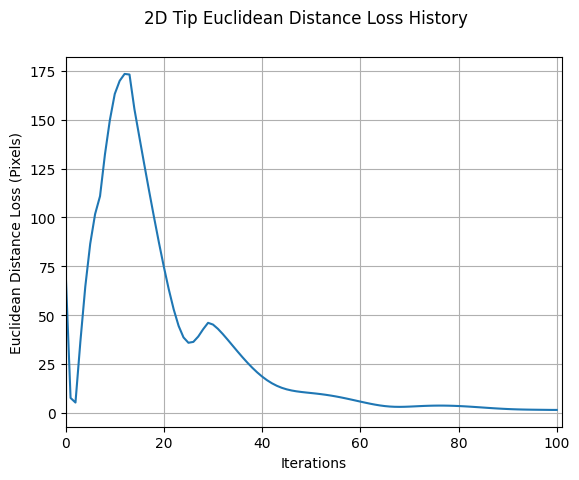

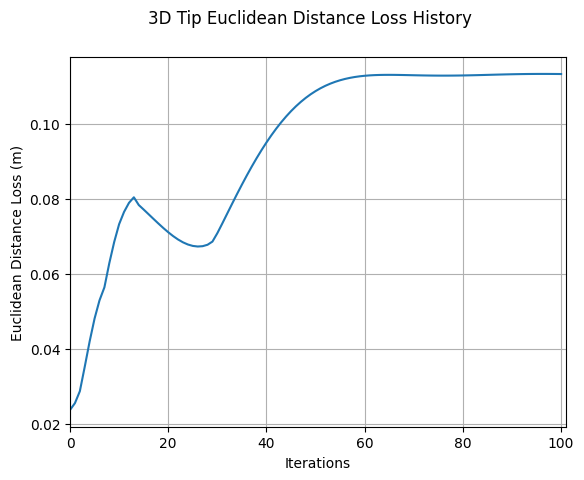

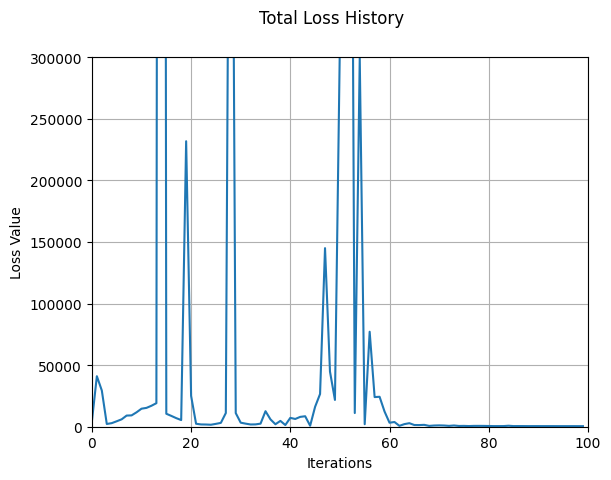

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:55,  1.78s/it, loss=7.48e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:13,  1.97s/it, loss=1.47e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:32,  2.19s/it, loss=970]    


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:37,  2.26s/it, loss=1.38e+4]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:11<03:39,  2.31s/it, loss=1.17e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:48,  2.43s/it, loss=1.38e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:00,  2.59s/it, loss=1.12e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:14,  2.77s/it, loss=2.55e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:27,  2.94s/it, loss=2.47e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:39,  3.11s/it, loss=3.91e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:48,  3.25s/it, loss=4.16e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:01,  3.42s/it, loss=4.96e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:11,  3.58s/it, loss=5.87e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:22,  3.74s/it, loss=6.87e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:45,  4.06s/it, loss=6.92e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:54,  4.22s/it, loss=5.43e+5]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:05,  4.41s/it, loss=7.93e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:11,  4.53s/it, loss=7.33e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:22,  4.72s/it, loss=7.45e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:34,  4.93s/it, loss=6.97e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:44,  5.12s/it, loss=1.77e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:52,  5.29s/it, loss=7.07e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<07:00,  5.46s/it, loss=6.79e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:06,  5.61s/it, loss=6.75e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:13,  5.78s/it, loss=6.05e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:20,  5.95s/it, loss=8.27e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:29,  6.16s/it, loss=7.98e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:38,  6.37s/it, loss=1.19e+6]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:42,  6.52s/it, loss=5.24e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:50,  6.73s/it, loss=4.75e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<08:00,  6.96s/it, loss=4.55e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:30<08:09,  7.19s/it, loss=4.53e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:12,  7.35s/it, loss=4.31e+3]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:16,  7.52s/it, loss=2.93e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:18,  7.68s/it, loss=1.28e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:21,  7.83s/it, loss=3.28e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:24,  8.00s/it, loss=3.36e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:28,  8.20s/it, loss=3.76e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:34,  8.43s/it, loss=4.78e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:35,  8.59s/it, loss=2.84e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:37,  8.76s/it, loss=2.09e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:38,  8.94s/it, loss=1.72e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:39,  9.11s/it, loss=1.47e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:41,  9.31s/it, loss=2.08e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:43,  9.52s/it, loss=1.32e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:44,  9.72s/it, loss=3.31e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:42,  9.86s/it, loss=930]    


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:42, 10.04s/it, loss=4.31e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:40, 10.21s/it, loss=895]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:39, 10.39s/it, loss=692]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:27<08:37, 10.55s/it, loss=655]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:36, 10.76s/it, loss=2.35e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:50<08:38, 11.03s/it, loss=540]    


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:02<08:35, 11.22s/it, loss=776]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:32, 11.39s/it, loss=614]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:27, 11.53s/it, loss=441]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:25, 11.75s/it, loss=1.01e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:50<08:19, 11.90s/it, loss=775]    


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:13, 12.04s/it, loss=635]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:15<08:07, 12.18s/it, loss=1.68e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:28<08:01, 12.35s/it, loss=554]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:41<07:57, 12.57s/it, loss=618]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:54<07:54, 12.81s/it, loss=647]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:08<07:48, 13.03s/it, loss=3.35e+4]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:22<07:43, 13.25s/it, loss=455]    


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:36<07:38, 13.48s/it, loss=3.51e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:50<07:31, 13.69s/it, loss=454]    


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:04<07:23, 13.86s/it, loss=477]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:18<07:14, 14.02s/it, loss=695]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:33<07:05, 14.19s/it, loss=451]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:48<06:56, 14.37s/it, loss=493]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:03<06:49, 14.62s/it, loss=462]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:18<06:37, 14.73s/it, loss=456]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:33<06:27, 14.89s/it, loss=470]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:49<06:18, 15.15s/it, loss=1.52e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:05<06:08, 15.34s/it, loss=478]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:21<05:56, 15.49s/it, loss=1.57e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:37<05:43, 15.62s/it, loss=551]    


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:53<05:34, 15.92s/it, loss=8.65e+4]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:10<05:21, 16.05s/it, loss=533]    


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:26<05:07, 16.21s/it, loss=626]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:43<04:54, 16.33s/it, loss=441]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:00<04:40, 16.48s/it, loss=639]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:17<04:26, 16.68s/it, loss=433]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:34<04:13, 16.90s/it, loss=3.56e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:51<03:58, 17.04s/it, loss=441]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:09<03:44, 17.25s/it, loss=1.35e+4]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:27<03:29, 17.47s/it, loss=1.15e+5]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:45<03:13, 17.63s/it, loss=438]    


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:03<02:57, 17.77s/it, loss=7.31e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:22<02:41, 17.94s/it, loss=460]    


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:40<02:25, 18.21s/it, loss=5.38e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:59<02:08, 18.42s/it, loss=1.72e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:18<01:51, 18.54s/it, loss=447]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:38<01:34, 18.81s/it, loss=405]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:57<01:15, 18.95s/it, loss=644]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:17<00:57, 19.19s/it, loss=429]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:36<00:38, 19.32s/it, loss=431]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:56<00:19, 19.47s/it, loss=912]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:16<00:00, 10.97s/it, loss=438]


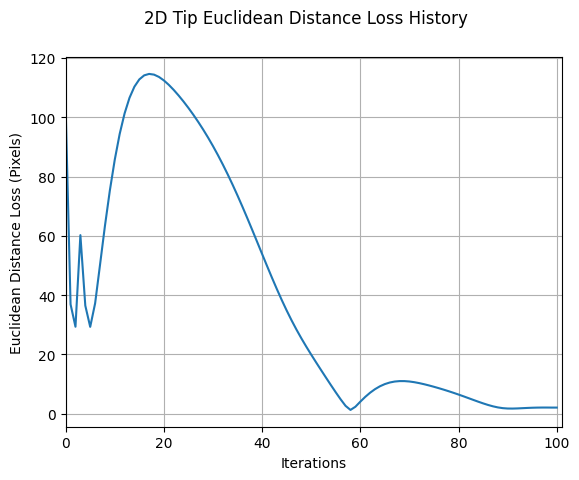

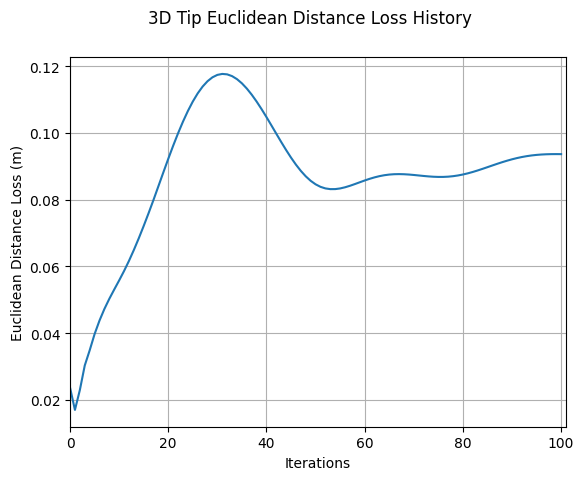

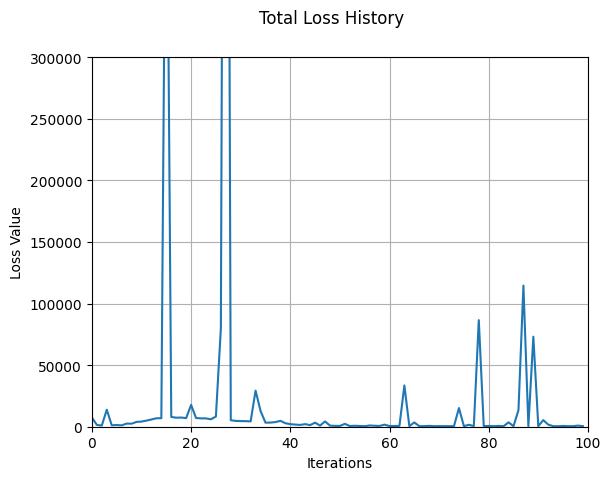

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:54,  1.76s/it, loss=8.8e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:04,  1.88s/it, loss=1.17e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:13,  1.99s/it, loss=2.26e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:24,  2.13s/it, loss=2.33e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:32,  2.23s/it, loss=6.42e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:43,  2.38s/it, loss=3.08e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<03:55,  2.53s/it, loss=4.88e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:10,  2.72s/it, loss=2.55e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:27,  2.94s/it, loss=1.8e+3] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:39,  3.11s/it, loss=1.25e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:05,  3.43s/it, loss=783]    


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:10,  3.53s/it, loss=1.48e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:18,  3.66s/it, loss=572]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:28,  3.82s/it, loss=4.5e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:39,  3.99s/it, loss=1.2e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:48,  4.15s/it, loss=2.15e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<06:01,  4.35s/it, loss=1.33e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:12,  4.54s/it, loss=767]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:21,  4.70s/it, loss=7.76e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:30,  4.88s/it, loss=455]    


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:39,  5.05s/it, loss=466]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:49,  5.25s/it, loss=498]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<06:59,  5.45s/it, loss=3.99e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:07,  5.63s/it, loss=617]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:15,  5.81s/it, loss=651]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:23,  5.99s/it, loss=914]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:35,  6.24s/it, loss=2.3e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:40,  6.39s/it, loss=630]   


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:44,  6.54s/it, loss=569]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:49,  6.71s/it, loss=467]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<07:58,  6.94s/it, loss=399]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:03,  7.12s/it, loss=713]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:14,  7.38s/it, loss=383]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:18,  7.55s/it, loss=1.62e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:21,  7.72s/it, loss=800]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:01<08:23,  7.87s/it, loss=1.23e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:27,  8.06s/it, loss=445]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:30,  8.23s/it, loss=416]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:27<08:33,  8.42s/it, loss=422]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:36<08:36,  8.60s/it, loss=564]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:42,  8.85s/it, loss=766]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:41,  9.00s/it, loss=1.85e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:40,  9.14s/it, loss=655]    


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:41,  9.32s/it, loss=624]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:42,  9.49s/it, loss=733]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:42,  9.67s/it, loss=863]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:46,  9.94s/it, loss=7.33e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:56<08:48, 10.17s/it, loss=565]    


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:46, 10.33s/it, loss=531]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:43, 10.46s/it, loss=486]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:40, 10.63s/it, loss=740]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:37, 10.79s/it, loss=385]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:51<08:34, 10.95s/it, loss=2.01e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:02<08:33, 11.16s/it, loss=529]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:30, 11.34s/it, loss=553]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:27, 11.55s/it, loss=2.72e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:22, 11.69s/it, loss=949]    


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:50<08:18, 11.86s/it, loss=404]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:17, 12.13s/it, loss=477]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:16<08:10, 12.26s/it, loss=565]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:29<08:04, 12.42s/it, loss=369]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:42<08:01, 12.68s/it, loss=3.55e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:55<07:57, 12.89s/it, loss=367]    


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:09<07:52, 13.13s/it, loss=1.52e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:23<07:45, 13.30s/it, loss=531]    


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:36<07:37, 13.46s/it, loss=340]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:50<07:30, 13.65s/it, loss=2.62e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:05<07:22, 13.83s/it, loss=1.35e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:19<07:16, 14.09s/it, loss=1.65e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:34<07:07, 14.25s/it, loss=457]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:49<07:00, 14.49s/it, loss=876]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:04<06:50, 14.66s/it, loss=1.05e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:43, 14.93s/it, loss=2.67e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:35<06:30, 15.04s/it, loss=350]    


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:50<06:18, 15.13s/it, loss=1.65e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:06<06:07, 15.30s/it, loss=714]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:22<05:55, 15.46s/it, loss=2.01e+5]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:38<05:44, 15.65s/it, loss=383]    


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:54<05:32, 15.84s/it, loss=493]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:11<05:21, 16.08s/it, loss=614]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:08, 16.25s/it, loss=2.43e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:56, 16.50s/it, loss=531]    


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:01<04:42, 16.61s/it, loss=335]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:29, 16.83s/it, loss=369]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:36<04:15, 17.05s/it, loss=3.05e+5]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<04:01, 17.27s/it, loss=492]    


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:46, 17.40s/it, loss=1.59e+6]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:30, 17.55s/it, loss=474]    


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:15, 17.79s/it, loss=400]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:59, 17.94s/it, loss=548]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:25<02:43, 18.12s/it, loss=7.2e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:44<02:26, 18.29s/it, loss=3.68e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:03<02:09, 18.52s/it, loss=7.47e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:22<01:52, 18.68s/it, loss=637]    


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:41<01:34, 18.93s/it, loss=1.51e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:01<01:16, 19.12s/it, loss=1.01e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:20<00:57, 19.19s/it, loss=449]    


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:40<00:38, 19.38s/it, loss=4.22e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [18:00<00:19, 19.66s/it, loss=2.32e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:21<00:00, 11.01s/it, loss=357]   


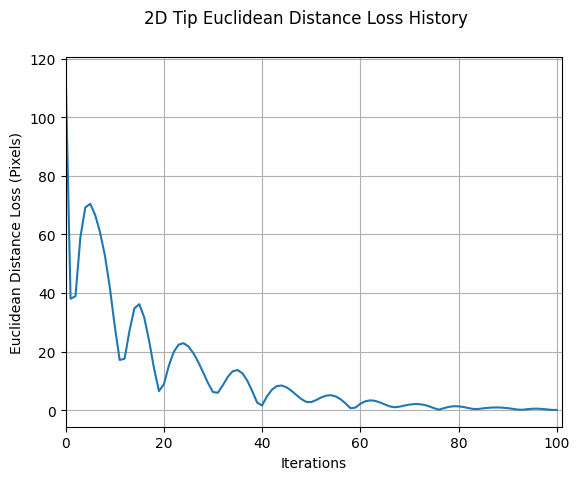

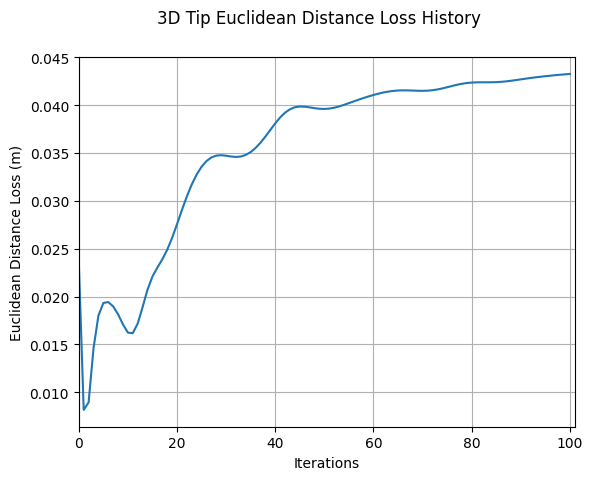

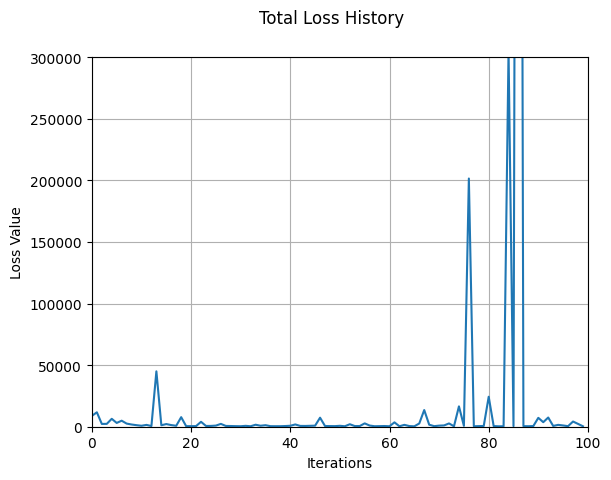

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:02<03:56,  2.39s/it, loss=7.42e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:04<03:28,  2.12s/it, loss=6.48e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:30,  2.17s/it, loss=1.61e+4]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:32,  2.22s/it, loss=4.49e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:11<03:44,  2.36s/it, loss=9.42e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:14<03:53,  2.49s/it, loss=2.96e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:17<04:05,  2.64s/it, loss=2.4e+4] 


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:16,  2.79s/it, loss=3.27e+4]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:29,  2.97s/it, loss=5.1e+4] 


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:42,  3.14s/it, loss=5.19e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:53,  3.30s/it, loss=6.09e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:03,  3.45s/it, loss=8.12e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:16,  3.64s/it, loss=7.74e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:28,  3.82s/it, loss=8.24e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:43,  4.04s/it, loss=2.02e+5]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:50,  4.17s/it, loss=8.88e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:00,  4.35s/it, loss=9.02e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:10,  4.52s/it, loss=8.91e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:18,  4.67s/it, loss=1.16e+5]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:27,  4.84s/it, loss=1.01e+5]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:34,  5.00s/it, loss=1.09e+5]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:43,  5.18s/it, loss=1.21e+5]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<06:52,  5.36s/it, loss=1.37e+5]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:02,  5.55s/it, loss=1.51e+5]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:09,  5.72s/it, loss=1.68e+5]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:22,  5.98s/it, loss=1.85e+5]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:29,  6.16s/it, loss=2.09e+5]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:35,  6.32s/it, loss=2.22e+5]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:41,  6.50s/it, loss=2.4e+5] 


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:47,  6.67s/it, loss=2.56e+5]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:21<07:53,  6.86s/it, loss=2.72e+5]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:04,  7.12s/it, loss=2.91e+5]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:08,  7.29s/it, loss=3.02e+5]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:10,  7.44s/it, loss=3.14e+5]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:19,  7.68s/it, loss=3.23e+5]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:01<08:25,  7.90s/it, loss=3.32e+5]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:26,  8.05s/it, loss=3.39e+5]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:18<08:28,  8.21s/it, loss=3.44e+5]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:27<08:30,  8.37s/it, loss=3.55e+5]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:36<08:32,  8.54s/it, loss=3.51e+5]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:45<08:34,  8.72s/it, loss=3.57e+5]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:54<08:35,  8.89s/it, loss=3.59e+5]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:04<08:41,  9.14s/it, loss=3.56e+5]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:42,  9.33s/it, loss=3.57e+5]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:42,  9.50s/it, loss=3.52e+5]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:41,  9.66s/it, loss=3.58e+5]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:44<08:40,  9.82s/it, loss=3.36e+5]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:54<08:38,  9.97s/it, loss=3.27e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:05<08:41, 10.23s/it, loss=3.19e+5]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:16<08:39, 10.39s/it, loss=3.1e+5] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:27<08:37, 10.57s/it, loss=3.03e+5]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:38<08:38, 10.81s/it, loss=2.94e+5]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:49<08:34, 10.96s/it, loss=2.86e+5]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:01<08:31, 11.11s/it, loss=2.78e+5]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:13<08:31, 11.36s/it, loss=2.7e+5] 


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:25<08:26, 11.51s/it, loss=2.84e+5]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:37<08:21, 11.67s/it, loss=2.56e+5]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:49<08:17, 11.84s/it, loss=2.49e+5]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:01<08:11, 12.00s/it, loss=2.43e+5]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:14<08:07, 12.19s/it, loss=2.36e+5]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:27<08:02, 12.37s/it, loss=2.31e+5]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:40<08:00, 12.64s/it, loss=2.26e+5]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:53<07:54, 12.83s/it, loss=2.23e+5]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:07<07:47, 13.00s/it, loss=2.15e+5]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:20<07:41, 13.17s/it, loss=2.12e+5]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:34<07:35, 13.39s/it, loss=2.03e+5]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:48<07:28, 13.59s/it, loss=1.98e+5]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:03<07:20, 13.78s/it, loss=2.93e+5]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:17<07:13, 13.97s/it, loss=1.89e+5]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:32<07:07, 14.24s/it, loss=1.85e+5]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:47<06:58, 14.42s/it, loss=1.8e+5] 


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:01<06:47, 14.55s/it, loss=1.76e+5]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:17<06:37, 14.73s/it, loss=1.72e+5]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:32<06:29, 14.96s/it, loss=1.69e+5]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:48<06:17, 15.11s/it, loss=1.64e+5]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:03<06:05, 15.24s/it, loss=1.62e+5]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:19<05:54, 15.40s/it, loss=1.6e+5] 


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:35<05:42, 15.58s/it, loss=1.54e+5]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:52<05:34, 15.93s/it, loss=1.51e+5]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:08<05:21, 16.06s/it, loss=1.48e+5]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:25<05:07, 16.21s/it, loss=1.46e+5]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:41<04:55, 16.39s/it, loss=1.56e+5]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:58<04:41, 16.59s/it, loss=1.39e+5]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:15<04:27, 16.71s/it, loss=1.39e+5]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:33<04:13, 16.88s/it, loss=1.17e+8]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:50<03:58, 17.06s/it, loss=1.32e+5]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:08<03:44, 17.26s/it, loss=1.3e+5] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:26<03:29, 17.44s/it, loss=1.28e+5]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:44<03:13, 17.59s/it, loss=1.25e+5]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:02<02:58, 17.83s/it, loss=1.23e+5]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:20<02:41, 17.96s/it, loss=1.21e+5]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:39<02:25, 18.15s/it, loss=1.19e+5]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:58<02:08, 18.34s/it, loss=2.09e+6]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:17<01:51, 18.58s/it, loss=1.15e+5]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:36<01:33, 18.78s/it, loss=1.16e+5]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:56<01:15, 18.95s/it, loss=1.12e+5]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:15<00:57, 19.20s/it, loss=1.09e+5]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:35<00:38, 19.30s/it, loss=1.08e+5]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:55<00:19, 19.50s/it, loss=1.07e+5]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:15<00:00, 10.95s/it, loss=1.05e+5]


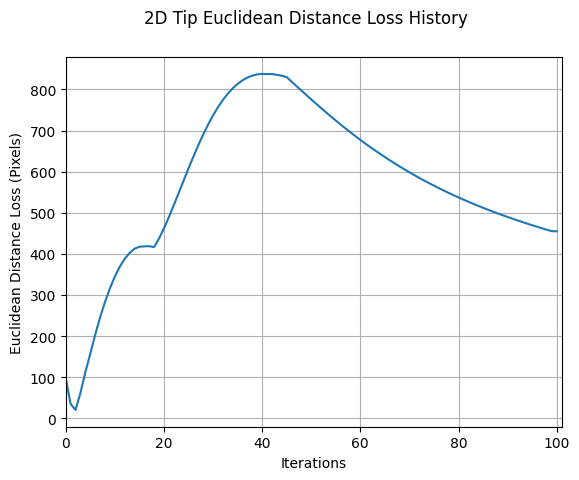

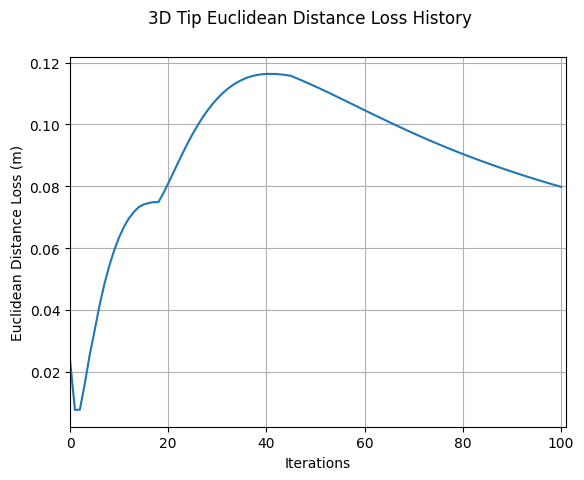

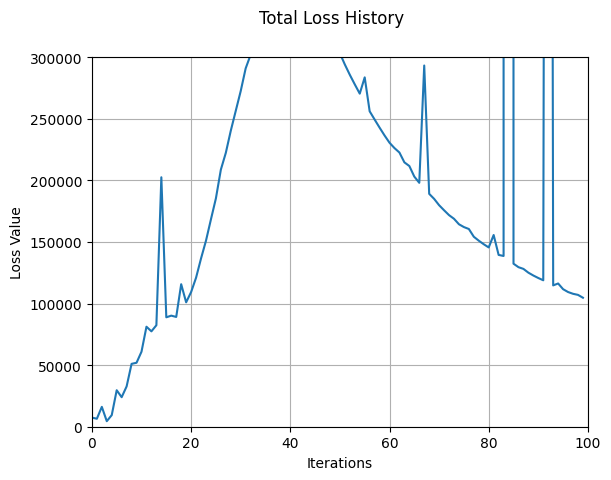

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:53,  1.76s/it, loss=5.77e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:01,  1.85s/it, loss=2.52e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:14,  2.01s/it, loss=3.25e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:24,  2.13s/it, loss=4.94e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:38,  2.30s/it, loss=5.31e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:50,  2.45s/it, loss=7.35e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:04,  2.63s/it, loss=6.22e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:19,  2.82s/it, loss=3.63e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:33,  3.01s/it, loss=2.96e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:55,  3.29s/it, loss=1.67e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:02,  3.40s/it, loss=1.14e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:11,  3.54s/it, loss=1.1e+3] 


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:20,  3.68s/it, loss=1.07e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:31,  3.85s/it, loss=998]    


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:41,  4.01s/it, loss=1.08e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:51,  4.18s/it, loss=1.61e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:02,  4.37s/it, loss=1.14e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:14,  4.57s/it, loss=2.23e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:25,  4.76s/it, loss=1.19e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:33,  4.92s/it, loss=1.23e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:42,  5.10s/it, loss=1.54e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:51,  5.28s/it, loss=1.1e+3] 


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<06:58,  5.44s/it, loss=1.33e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:06,  5.61s/it, loss=718]    


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:13,  5.78s/it, loss=7e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:26,  6.03s/it, loss=1.8e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:31,  6.18s/it, loss=466]   


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:36,  6.34s/it, loss=508]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:08<07:44,  6.54s/it, loss=411]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:53,  6.76s/it, loss=474]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<07:59,  6.96s/it, loss=596]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:30<08:05,  7.14s/it, loss=656]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:38<08:11,  7.33s/it, loss=620]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:46<08:14,  7.49s/it, loss=1.11e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:54<08:16,  7.64s/it, loss=2.21e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:21,  7.84s/it, loss=2.21e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:26,  8.04s/it, loss=587]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:35,  8.31s/it, loss=499]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:35,  8.46s/it, loss=730]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:36,  8.61s/it, loss=4.41e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:37,  8.77s/it, loss=389]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:56<08:39,  8.96s/it, loss=1.1e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:38,  9.10s/it, loss=634]   


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:15<08:38,  9.26s/it, loss=2.04e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:25<08:43,  9.52s/it, loss=357]    


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:35<08:47,  9.77s/it, loss=2.91e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:46<08:46,  9.94s/it, loss=501]    


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:56<08:44, 10.09s/it, loss=509]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:07<08:44, 10.28s/it, loss=388]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:18<08:41, 10.42s/it, loss=408]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:29<08:43, 10.68s/it, loss=436]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:41<08:49, 11.04s/it, loss=798]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:52<08:43, 11.14s/it, loss=406]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:04<08:38, 11.26s/it, loss=1.39e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:15<08:32, 11.40s/it, loss=509]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:27<08:29, 11.57s/it, loss=364]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:40<08:27, 11.81s/it, loss=369]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:52<08:20, 11.93s/it, loss=351]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:04<08:15, 12.09s/it, loss=359]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:17<08:11, 12.29s/it, loss=342]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:30<08:04, 12.44s/it, loss=352]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:43<08:04, 12.74s/it, loss=358]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:57<07:58, 12.94s/it, loss=1.88e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:10<07:51, 13.10s/it, loss=342]    


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:24<07:45, 13.29s/it, loss=2.21e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:38<07:37, 13.46s/it, loss=343]    


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:52<07:32, 13.71s/it, loss=324]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:06<07:23, 13.87s/it, loss=398]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:21<07:16, 14.08s/it, loss=681]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:35<07:07, 14.24s/it, loss=352]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:51<07:00, 14.50s/it, loss=463]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:49, 14.62s/it, loss=347]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:21<06:38, 14.78s/it, loss=1.19e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:36<06:28, 14.93s/it, loss=800]    


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:17, 15.08s/it, loss=355]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:07, 15.32s/it, loss=336]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:56, 15.49s/it, loss=661]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:44, 15.65s/it, loss=577]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:31, 15.80s/it, loss=324]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:12<05:21, 16.06s/it, loss=334]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:29<05:07, 16.21s/it, loss=395]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:54, 16.38s/it, loss=334]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:41, 16.57s/it, loss=361]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:20<04:29, 16.84s/it, loss=376]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:37<04:14, 16.97s/it, loss=416]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<03:59, 17.07s/it, loss=1.47e+4]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:44, 17.23s/it, loss=1.36e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:29, 17.45s/it, loss=866]    


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:13, 17.63s/it, loss=423]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:58, 17.81s/it, loss=1.75e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:25<02:42, 18.05s/it, loss=338]    


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:25, 18.23s/it, loss=2.26e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:02<02:08, 18.42s/it, loss=4.29e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:21<01:51, 18.56s/it, loss=1.73e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:40<01:33, 18.75s/it, loss=321]    


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:00<01:15, 18.91s/it, loss=350]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:19<00:57, 19.05s/it, loss=1.4e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:39<00:38, 19.28s/it, loss=867]   


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:59<00:19, 19.49s/it, loss=373]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:19<00:00, 11.00s/it, loss=429]


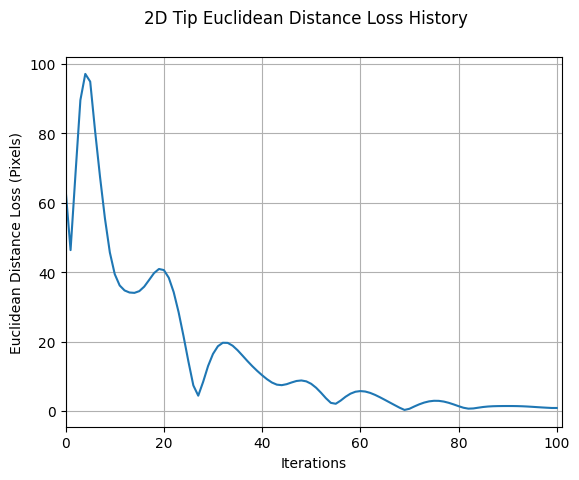

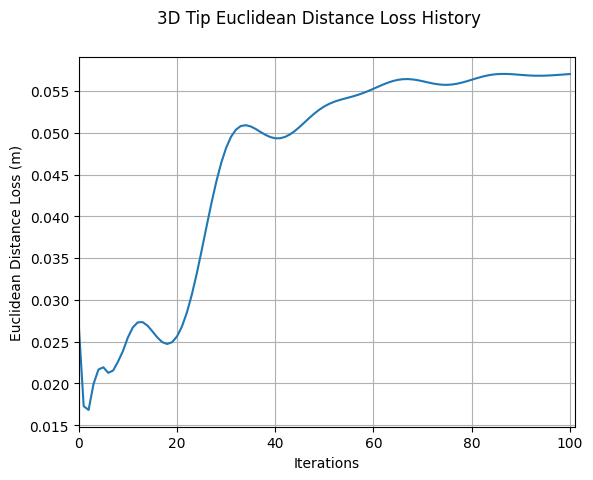

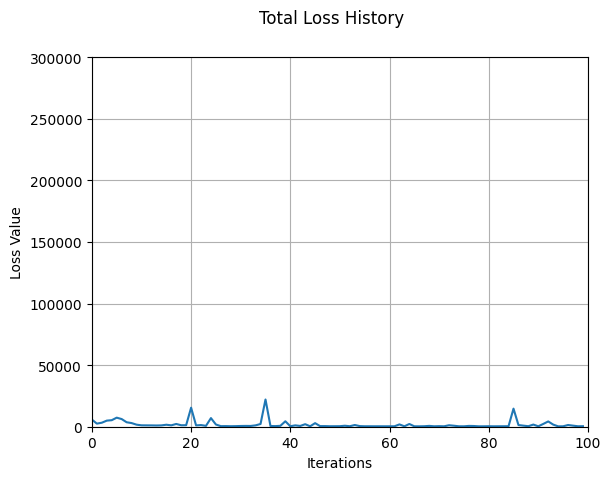

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:52,  1.75s/it, loss=1.9e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:02,  1.86s/it, loss=1.18e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:14,  2.01s/it, loss=1.04e+4]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:22,  2.11s/it, loss=1.76e+4]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:36,  2.28s/it, loss=2.6e+4] 


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:50,  2.46s/it, loss=3.34e+4]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:03,  2.62s/it, loss=4e+4]   


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:17,  2.80s/it, loss=2.08e+6]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:26,  2.93s/it, loss=5.39e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:35,  3.06s/it, loss=6.23e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:29<04:46,  3.21s/it, loss=7.38e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:33<04:56,  3.37s/it, loss=6.78e+4]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:08,  3.55s/it, loss=7.04e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:41<05:19,  3.72s/it, loss=7.25e+4]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:45<05:30,  3.88s/it, loss=7.48e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:50<05:43,  4.08s/it, loss=7.55e+4]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<05:57,  4.31s/it, loss=7.36e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:07,  4.49s/it, loss=7.2e+4] 


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:05<06:17,  4.65s/it, loss=7.05e+4]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:10<06:25,  4.82s/it, loss=6.88e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:15<06:36,  5.02s/it, loss=9.12e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:21<06:47,  5.22s/it, loss=6.39e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:27<06:55,  5.40s/it, loss=6.14e+4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:33<07:02,  5.56s/it, loss=5.99e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:39<07:13,  5.78s/it, loss=5.61e+4]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:46<07:23,  6.00s/it, loss=5.26e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:52<07:27,  6.14s/it, loss=4.97e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [01:59<07:33,  6.30s/it, loss=4.69e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:06<07:40,  6.49s/it, loss=4.4e+4] 


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:13<07:50,  6.73s/it, loss=4.56e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:20<07:56,  6.91s/it, loss=3.89e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:28<08:08,  7.18s/it, loss=3.66e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:36<08:10,  7.32s/it, loss=6.5e+4] 


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:44<08:14,  7.50s/it, loss=4.16e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:52<08:18,  7.67s/it, loss=4.02e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:00<08:21,  7.84s/it, loss=4.13e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:08<08:26,  8.04s/it, loss=4.14e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:17<08:28,  8.20s/it, loss=4.13e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:26<08:31,  8.38s/it, loss=4.14e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:35<08:37,  8.63s/it, loss=4.42e+4]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:44<08:39,  8.80s/it, loss=4.17e+4]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:53<08:37,  8.92s/it, loss=4.65e+4]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:03<08:38,  9.09s/it, loss=3.67e+4]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:13<08:38,  9.25s/it, loss=3.54e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:22<08:38,  9.43s/it, loss=3.1e+4] 


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:32<08:38,  9.60s/it, loss=2.85e+4]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:43<08:42,  9.86s/it, loss=5.03e+4]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:53<08:43, 10.06s/it, loss=2.51e+4]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:04<08:42, 10.25s/it, loss=2.39e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:15<08:44, 10.48s/it, loss=2.29e+4]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:26<08:41, 10.65s/it, loss=2.49e+4]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:37<08:39, 10.82s/it, loss=2.4e+4] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:49<08:40, 11.08s/it, loss=5.59e+4]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:01<08:35, 11.21s/it, loss=1.62e+4]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:12<08:31, 11.36s/it, loss=1.31e+4]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:24<08:27, 11.53s/it, loss=1.17e+4]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:36<08:22, 11.68s/it, loss=1.11e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:49<08:19, 11.90s/it, loss=1.36e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:01<08:14, 12.05s/it, loss=1.13e+4]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:14<08:08, 12.21s/it, loss=1.41e+4]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:27<08:03, 12.41s/it, loss=1.32e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:40<08:00, 12.64s/it, loss=1.43e+4]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:53<07:56, 12.87s/it, loss=3.46e+4]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:07<07:50, 13.06s/it, loss=2e+4]   


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:20<07:43, 13.23s/it, loss=1.7e+4]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:34<07:35, 13.41s/it, loss=1.76e+4]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:48<07:28, 13.59s/it, loss=2.08e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:03<07:24, 13.89s/it, loss=2.29e+4]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:17<07:14, 14.01s/it, loss=2.01e+4]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:32<07:05, 14.18s/it, loss=2.1e+4] 


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:46<06:57, 14.41s/it, loss=2.19e+4]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:02<06:48, 14.60s/it, loss=2.31e+4]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:17<06:40, 14.83s/it, loss=2.25e+4]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:32<06:28, 14.96s/it, loss=2.68e+4]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:48<06:17, 15.11s/it, loss=2.44e+4]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:04<06:08, 15.37s/it, loss=1.01e+5]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:20<05:58, 15.59s/it, loss=2.45e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:36<05:44, 15.67s/it, loss=2.52e+4]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:52<05:31, 15.80s/it, loss=4.5e+4] 


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:08<05:19, 15.99s/it, loss=5.05e+4]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:25<05:09, 16.28s/it, loss=3.19e+4]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:42<04:54, 16.37s/it, loss=2.24e+4]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [12:58<04:40, 16.52s/it, loss=2.12e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:15<04:26, 16.65s/it, loss=2.26e+4]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:33<04:13, 16.89s/it, loss=2.92e+4]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:50<03:59, 17.08s/it, loss=2.69e+4]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:08<03:43, 17.19s/it, loss=2.6e+4] 


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:26<03:28, 17.40s/it, loss=2.75e+4]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:44<03:14, 17.66s/it, loss=2.93e+4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:02<02:58, 17.85s/it, loss=3.32e+4]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:21<02:42, 18.03s/it, loss=3.22e+4]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:40<02:26, 18.26s/it, loss=3.38e+4]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [15:58<02:08, 18.39s/it, loss=3.51e+4]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:17<01:51, 18.56s/it, loss=3.67e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:36<01:33, 18.70s/it, loss=3.77e+4]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:56<01:15, 18.96s/it, loss=3.9e+4] 


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:15<00:57, 19.15s/it, loss=4e+4]  


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:35<00:38, 19.33s/it, loss=4.13e+4]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:55<00:19, 19.54s/it, loss=4.51e+4]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:15<00:00, 10.96s/it, loss=4.32e+4]


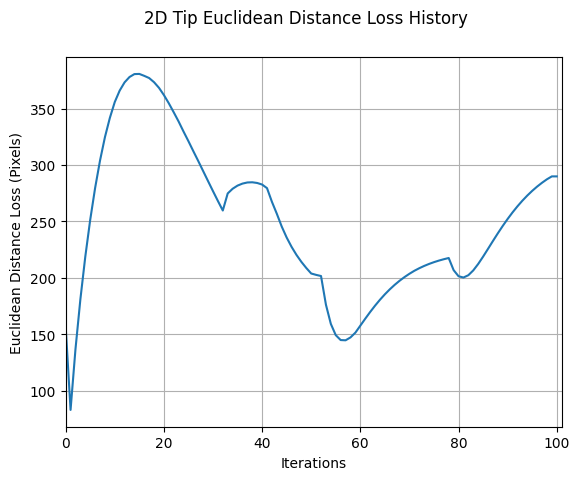

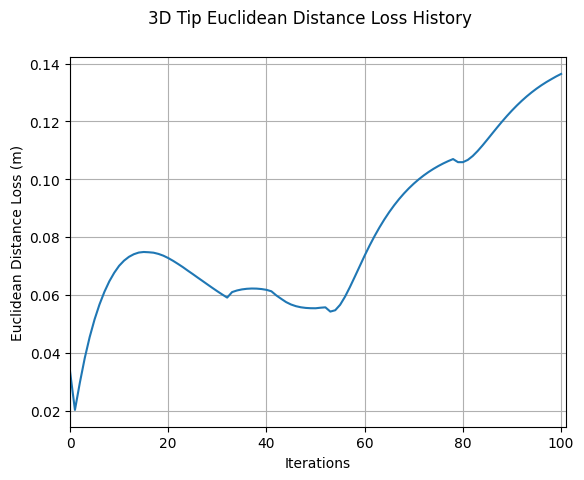

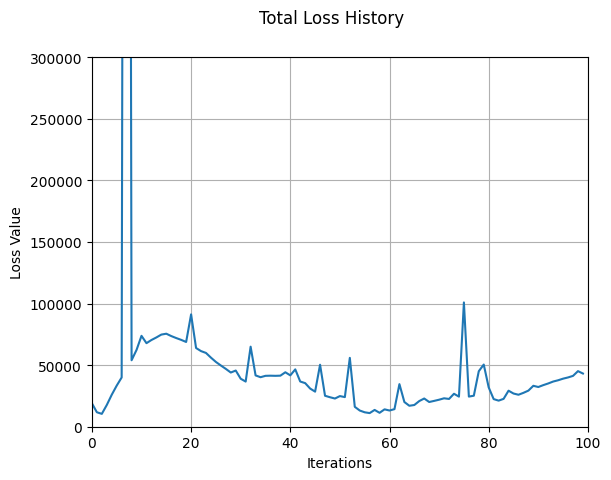

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:57,  1.79s/it, loss=9.8e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<02:59,  1.83s/it, loss=1.38e+5]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:13,  1.99s/it, loss=1.85e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:23,  2.12s/it, loss=1.24e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:39,  2.31s/it, loss=2.09e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:52,  2.47s/it, loss=2.93e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:14,  2.74s/it, loss=3.21e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:24,  2.87s/it, loss=2.71e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:35,  3.03s/it, loss=2.19e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:49,  3.21s/it, loss=1.71e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:57,  3.35s/it, loss=1.54e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:11,  3.54s/it, loss=8.02e+6]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:23,  3.72s/it, loss=1.42e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:43<05:32,  3.87s/it, loss=1.43e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:43,  4.04s/it, loss=1.49e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:52<05:55,  4.24s/it, loss=1.49e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:07,  4.42s/it, loss=1.47e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:16,  4.60s/it, loss=1.39e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:07<06:24,  4.75s/it, loss=1.27e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:34,  4.93s/it, loss=2.17e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:43,  5.11s/it, loss=616]    


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:57,  5.35s/it, loss=506]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<07:05,  5.53s/it, loss=554]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:13,  5.71s/it, loss=1.73e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:42<07:27,  5.96s/it, loss=671]    


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:48<07:32,  6.11s/it, loss=1.42e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:55<07:37,  6.27s/it, loss=654]    


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:02<07:40,  6.39s/it, loss=626]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:09<07:47,  6.59s/it, loss=575]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:16<07:53,  6.77s/it, loss=721]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:23<08:01,  6.98s/it, loss=556]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:31<08:08,  7.18s/it, loss=3.07e+3]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:39<08:15,  7.40s/it, loss=942]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:47<08:24,  7.64s/it, loss=392]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:55<08:27,  7.81s/it, loss=1.99e+3]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:04<08:31,  7.99s/it, loss=446]    


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:12<08:34,  8.16s/it, loss=4.91e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:21<08:36,  8.33s/it, loss=1.21e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:30<08:37,  8.48s/it, loss=1.02e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:39<08:44,  8.74s/it, loss=429]    


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:49<08:45,  8.90s/it, loss=453]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:58<08:49,  9.14s/it, loss=1.12e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:08<08:50,  9.30s/it, loss=848]    


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:18<08:49,  9.45s/it, loss=391]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:28<08:47,  9.60s/it, loss=416]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:38<08:47,  9.76s/it, loss=465]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:48<08:47,  9.96s/it, loss=398]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:59<08:50, 10.20s/it, loss=2.34e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:10<08:49, 10.38s/it, loss=576]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:21<08:46, 10.53s/it, loss=393]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:32<08:43, 10.69s/it, loss=636]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:43<08:40, 10.85s/it, loss=377]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:54<08:37, 11.02s/it, loss=368]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:06<08:38, 11.28s/it, loss=7.27e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:18<08:35, 11.45s/it, loss=570]    


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:30<08:32, 11.64s/it, loss=563]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:42<08:27, 11.80s/it, loss=372]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:55<08:22, 11.97s/it, loss=5.18e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:07<08:17, 12.12s/it, loss=348]    


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:20<08:14, 12.36s/it, loss=8.76e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:33<08:08, 12.53s/it, loss=386]    


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:47<08:09, 12.88s/it, loss=373]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [08:01<08:06, 13.15s/it, loss=348]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:14<07:57, 13.27s/it, loss=463]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:28<07:50, 13.45s/it, loss=1.84e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:42<07:42, 13.61s/it, loss=421]    


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:56<07:34, 13.77s/it, loss=1.21e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:10<07:25, 13.93s/it, loss=1.39e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:25<07:18, 14.16s/it, loss=427]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:40<07:08, 14.29s/it, loss=2.67e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:55<06:59, 14.46s/it, loss=353]    


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:10<06:50, 14.65s/it, loss=3.14e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:25<06:41, 14.85s/it, loss=1.7e+3] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:41<06:31, 15.06s/it, loss=386]   


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:56<06:19, 15.19s/it, loss=366]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:12<06:08, 15.34s/it, loss=493]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:28<05:57, 15.53s/it, loss=378]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:44<05:46, 15.77s/it, loss=386]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [12:00<05:33, 15.88s/it, loss=1.32e+6]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:17<05:20, 16.03s/it, loss=5.09e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:33<05:07, 16.21s/it, loss=338]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:50<04:56, 16.46s/it, loss=358]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:07<04:41, 16.57s/it, loss=361]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:24<04:27, 16.74s/it, loss=373]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:42<04:14, 16.94s/it, loss=360]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:59<04:00, 17.20s/it, loss=554]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:17<03:45, 17.33s/it, loss=375]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:35<03:29, 17.50s/it, loss=344]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:53<03:14, 17.72s/it, loss=483]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:12<02:59, 17.92s/it, loss=433]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:30<02:42, 18.09s/it, loss=365]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:49<02:27, 18.38s/it, loss=384]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:08<02:09, 18.54s/it, loss=567]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:27<01:52, 18.69s/it, loss=402]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:46<01:34, 18.87s/it, loss=332]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:06<01:16, 19.06s/it, loss=378]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:25<00:57, 19.21s/it, loss=460]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:45<00:38, 19.37s/it, loss=461]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [18:05<00:19, 19.50s/it, loss=461]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:25<00:00, 11.06s/it, loss=2.41e+3]


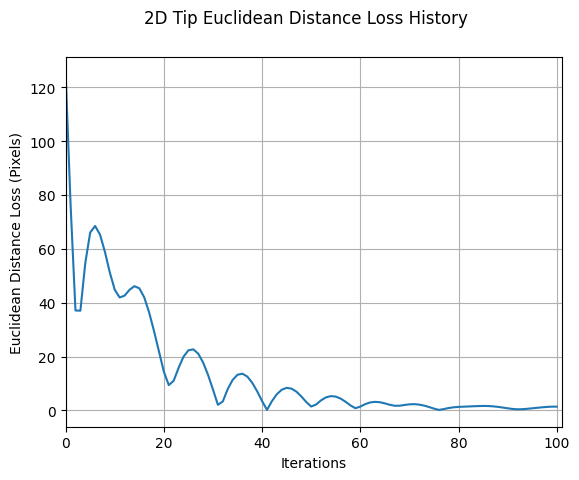

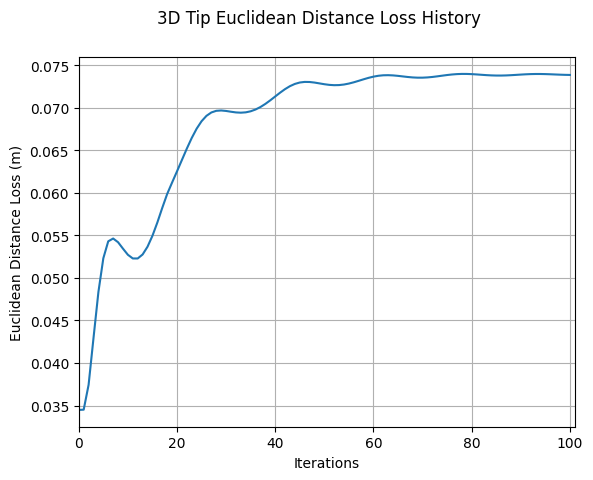

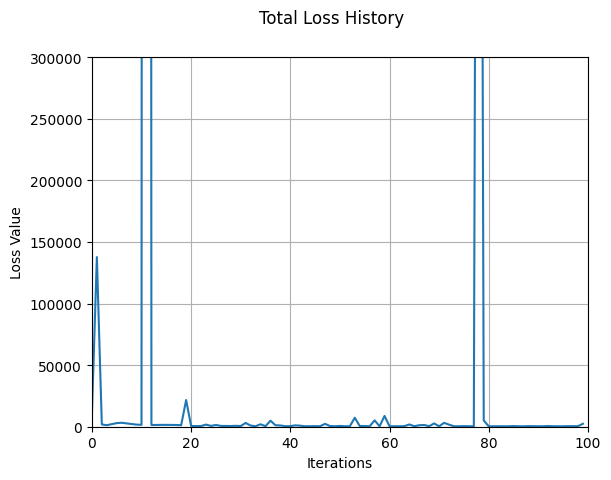

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:51,  1.73s/it, loss=2.26e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:02,  1.86s/it, loss=3.14e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:17,  2.03s/it, loss=1.65e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:23,  2.12s/it, loss=663]    


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:36,  2.27s/it, loss=5.25e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:48,  2.44s/it, loss=3.6e+3] 


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:01,  2.59s/it, loss=4.03e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:10,  2.72s/it, loss=4.53e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:22<04:25,  2.92s/it, loss=5.96e+4]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:37,  3.08s/it, loss=4.02e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:29<04:48,  3.24s/it, loss=8.1e+4] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:33<05:00,  3.41s/it, loss=6.31e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:37<05:10,  3.57s/it, loss=684]    


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:41<05:22,  3.75s/it, loss=593]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:34,  3.94s/it, loss=734]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:50<05:52,  4.19s/it, loss=1.23e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:55<06:02,  4.37s/it, loss=1.96e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:00<06:11,  4.53s/it, loss=3.45e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:05<06:21,  4.71s/it, loss=1.9e+3] 


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:10<06:31,  4.89s/it, loss=1.91e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:40,  5.07s/it, loss=1.06e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:51,  5.27s/it, loss=5.07e+5]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<07:00,  5.46s/it, loss=948]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:08,  5.64s/it, loss=3.44e+3]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:16,  5.81s/it, loss=554]    


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:46<07:24,  6.00s/it, loss=884]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:43,  6.35s/it, loss=650]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:46,  6.47s/it, loss=771]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:49,  6.61s/it, loss=780]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:53,  6.77s/it, loss=1.07e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<08:00,  6.97s/it, loss=4.74e+3]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:06,  7.16s/it, loss=1.59e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:11,  7.34s/it, loss=963]    


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:18,  7.55s/it, loss=2.03e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:23,  7.74s/it, loss=601]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:32,  8.00s/it, loss=3.62e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:31,  8.12s/it, loss=614]    


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:30,  8.23s/it, loss=636]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:31,  8.39s/it, loss=527]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:33,  8.55s/it, loss=639]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:34,  8.73s/it, loss=1.83e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:35,  8.89s/it, loss=496]    


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:40,  9.14s/it, loss=663]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:41,  9.31s/it, loss=534]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:40,  9.47s/it, loss=510]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:41,  9.65s/it, loss=579]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:45,  9.92s/it, loss=650]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:42, 10.05s/it, loss=657]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:42, 10.24s/it, loss=1.3e+4]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:18<09:02, 10.85s/it, loss=527]   


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:29<08:55, 10.93s/it, loss=1.43e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:41<08:50, 11.05s/it, loss=4.47e+3]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:52<08:43, 11.14s/it, loss=5.67e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:03<08:37, 11.25s/it, loss=500]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:15<08:33, 11.42s/it, loss=511]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:27<08:28, 11.56s/it, loss=513]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:39<08:23, 11.71s/it, loss=631]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:51<08:18, 11.87s/it, loss=485]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:04<08:13, 12.05s/it, loss=510]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:17<08:09, 12.23s/it, loss=579]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:29<08:04, 12.43s/it, loss=530]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:43<08:05, 12.77s/it, loss=5.15e+5]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:56<07:59, 12.96s/it, loss=523]    


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:10<07:53, 13.15s/it, loss=449]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:24<07:46, 13.32s/it, loss=466]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:38<07:40, 13.53s/it, loss=591]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:52<07:32, 13.70s/it, loss=1.7e+4]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:06<07:23, 13.86s/it, loss=476]   


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:14, 14.02s/it, loss=451]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:35<07:08, 14.28s/it, loss=992]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:50<07:00, 14.51s/it, loss=6e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:50, 14.65s/it, loss=802] 


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:21<06:40, 14.84s/it, loss=437]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:36<06:29, 14.99s/it, loss=464]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:52<06:19, 15.17s/it, loss=1.64e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:07, 15.31s/it, loss=477]    


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:55, 15.46s/it, loss=540]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:44, 15.64s/it, loss=929]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:56<05:33, 15.89s/it, loss=487]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:12<05:21, 16.07s/it, loss=2.92e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:29<05:07, 16.20s/it, loss=468]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:54, 16.38s/it, loss=425]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:03<04:43, 16.65s/it, loss=484]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:20<04:27, 16.75s/it, loss=1.52e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:37<04:13, 16.91s/it, loss=460]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<03:59, 17.08s/it, loss=520]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:44, 17.31s/it, loss=675]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:29, 17.46s/it, loss=520]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:13, 17.62s/it, loss=6.66e+4]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:58, 17.83s/it, loss=2.1e+3] 


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:25<02:41, 17.98s/it, loss=458]   


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:25, 18.17s/it, loss=476]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:02<02:08, 18.37s/it, loss=565]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:21<01:51, 18.58s/it, loss=461]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:40<01:33, 18.75s/it, loss=550]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:00<01:15, 18.94s/it, loss=457]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:20<00:57, 19.21s/it, loss=561]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:39<00:38, 19.39s/it, loss=2.45e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:59<00:19, 19.52s/it, loss=454]    


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:19<00:00, 11.00s/it, loss=469]


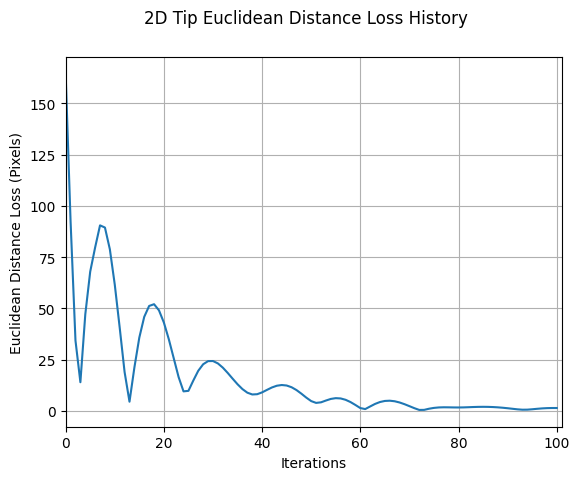

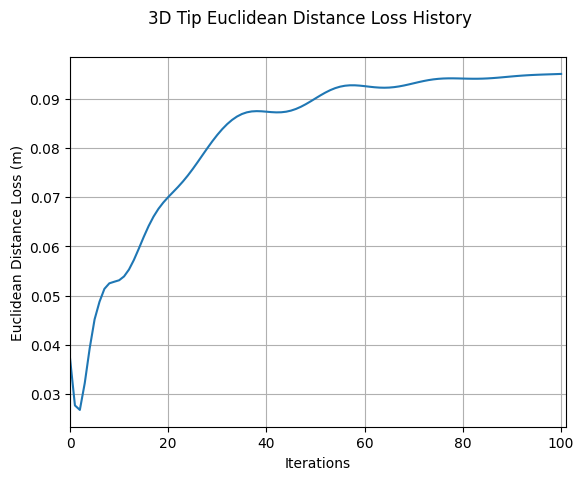

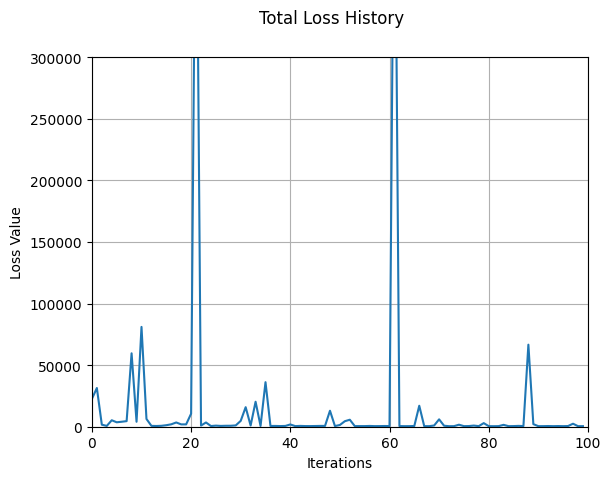

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:02<03:58,  2.41s/it, loss=6.84e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:04<03:29,  2.14s/it, loss=2.8e+3] 


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:06<03:28,  2.15s/it, loss=1.38e+4]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:31,  2.21s/it, loss=2.47e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:11<03:43,  2.35s/it, loss=1.33e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:14<03:51,  2.46s/it, loss=1.71e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:17<04:04,  2.62s/it, loss=2.29e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:17,  2.80s/it, loss=3.15e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:31,  2.99s/it, loss=4.89e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:43,  3.14s/it, loss=5.07e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:54,  3.31s/it, loss=6.02e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:05,  3.47s/it, loss=7.12e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:15,  3.63s/it, loss=7.85e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:26,  3.80s/it, loss=8.61e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:42,  4.03s/it, loss=9.94e+3]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:52,  4.19s/it, loss=1e+4]   


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:04,  4.39s/it, loss=1.05e+4]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:14,  4.57s/it, loss=1.09e+4]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:07<06:26,  4.78s/it, loss=1.62e+4]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:33,  4.92s/it, loss=1.26e+4]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:41,  5.08s/it, loss=4.16e+4]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:50,  5.26s/it, loss=1.81e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<06:58,  5.43s/it, loss=1.24e+4]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:05,  5.60s/it, loss=1.29e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:13,  5.78s/it, loss=1.25e+4]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:23,  6.00s/it, loss=1.24e+4]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:30,  6.17s/it, loss=1.25e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:40,  6.40s/it, loss=1.23e+4]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:08<07:48,  6.59s/it, loss=2.23e+4]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:53,  6.77s/it, loss=1.41e+4]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:23<08:03,  7.01s/it, loss=1.19e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:30<08:06,  7.16s/it, loss=1.17e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:38<08:10,  7.32s/it, loss=1.17e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:46<08:14,  7.49s/it, loss=1.12e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:54<08:17,  7.65s/it, loss=3.35e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:20,  7.82s/it, loss=1.07e+4]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:11<08:27,  8.05s/it, loss=1.06e+4]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:20<08:35,  8.32s/it, loss=1.02e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:28<08:35,  8.45s/it, loss=1.01e+4]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:37,  8.62s/it, loss=9.66e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:36,  8.76s/it, loss=9.41e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:56<08:38,  8.94s/it, loss=9.08e+3]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:39,  9.11s/it, loss=8.79e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:15<08:40,  9.30s/it, loss=1.88e+4]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:25<08:45,  9.56s/it, loss=8.29e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:35<08:45,  9.72s/it, loss=8.02e+3]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:46<08:42,  9.87s/it, loss=1.12e+5]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:56<08:41, 10.03s/it, loss=7.4e+3] 


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:07<08:40, 10.20s/it, loss=7.29e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:38, 10.36s/it, loss=7.38e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:39, 10.61s/it, loss=8.79e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:40<08:39, 10.82s/it, loss=1.06e+4]


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:51<08:34, 10.95s/it, loss=6.2e+3] 


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:03<08:30, 11.10s/it, loss=6.04e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:28, 11.29s/it, loss=5.77e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:24, 11.46s/it, loss=5.47e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:24, 11.73s/it, loss=8.65e+3]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:51<08:20, 11.92s/it, loss=8.33e+4]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:17, 12.14s/it, loss=4.9e+3] 


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:16<08:10, 12.25s/it, loss=4.76e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:29<08:04, 12.41s/it, loss=2.75e+4]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:42<08:02, 12.69s/it, loss=4.36e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:55<07:56, 12.88s/it, loss=4.2e+3] 


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:09<07:52, 13.14s/it, loss=4.05e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:23<07:45, 13.30s/it, loss=4.21e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:37<07:37, 13.47s/it, loss=4.21e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:51<07:34, 13.78s/it, loss=3.66e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:06<07:27, 13.97s/it, loss=4.37e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:17, 14.12s/it, loss=3.28e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:35<07:10, 14.33s/it, loss=3.16e+3]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:50<07:00, 14.51s/it, loss=4.22e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:51, 14.68s/it, loss=2.97e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:39, 14.81s/it, loss=2.82e+3]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:35<06:28, 14.96s/it, loss=4.08e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:17, 15.10s/it, loss=3.67e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:08, 15.36s/it, loss=2.48e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:56, 15.48s/it, loss=2.58e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:44, 15.65s/it, loss=2.42e+3]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:34, 15.92s/it, loss=2.32e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:12<05:23, 16.16s/it, loss=2.2e+3] 


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:08, 16.24s/it, loss=2.17e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:54, 16.39s/it, loss=2.01e+3]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:41, 16.56s/it, loss=1.81e+4]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:28, 16.76s/it, loss=1.96e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:36<04:13, 16.93s/it, loss=1.86e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<03:59, 17.10s/it, loss=1.71e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:44, 17.23s/it, loss=1.73e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:29<03:29, 17.44s/it, loss=1.69e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:47<03:13, 17.61s/it, loss=1.56e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:57, 17.75s/it, loss=1.55e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:24<02:42, 18.02s/it, loss=2.05e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:25, 18.19s/it, loss=1.55e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:01<02:08, 18.31s/it, loss=1.49e+3]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:20<01:50, 18.46s/it, loss=1.65e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:39<01:33, 18.70s/it, loss=3.91e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:59<01:15, 18.92s/it, loss=2.28e+6]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:18<00:57, 19.10s/it, loss=1.23e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:38<00:38, 19.32s/it, loss=1.17e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:58<00:19, 19.51s/it, loss=1.19e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:18<00:00, 10.99s/it, loss=1.17e+3]


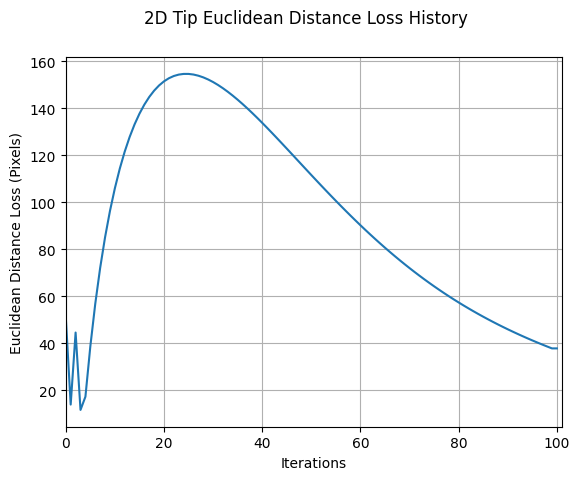

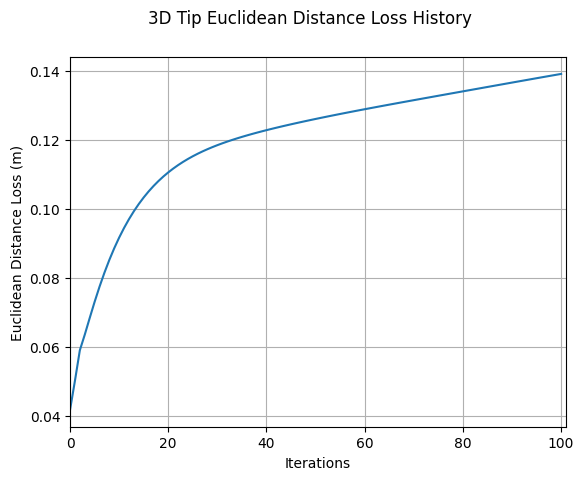

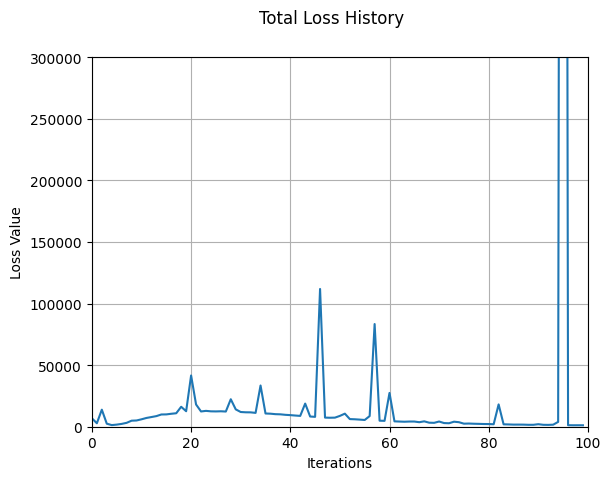

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:57,  1.79s/it, loss=8.04e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:04,  1.89s/it, loss=1.22e+10]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:17,  2.03s/it, loss=2.22e+4] 


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:26,  2.15s/it, loss=1.63e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:39,  2.31s/it, loss=1.63e+3]


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:51,  2.46s/it, loss=2.31e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:06,  2.65s/it, loss=5.74e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:18,  2.81s/it, loss=4.48e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:29,  2.96s/it, loss=5.82e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:53,  3.26s/it, loss=6.53e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<05:03,  3.41s/it, loss=7.44e+4]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:10,  3.53s/it, loss=8.35e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:20,  3.68s/it, loss=1.34e+4]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:32,  3.87s/it, loss=9.79e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:44,  4.06s/it, loss=1.77e+4]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:52,  4.20s/it, loss=8.69e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:04,  4.39s/it, loss=8.64e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:14,  4.56s/it, loss=8.52e+3]


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:23,  4.73s/it, loss=8.68e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:12<06:32,  4.91s/it, loss=8.7e+3] 


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:43,  5.10s/it, loss=8.82e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:55,  5.33s/it, loss=1.03e+4]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:29<07:02,  5.49s/it, loss=9.06e+3]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:35<07:09,  5.65s/it, loss=1.53e+4]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:16,  5.82s/it, loss=9.38e+3]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:48<07:30,  6.09s/it, loss=9.49e+3]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:34,  6.23s/it, loss=1.42e+4]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:39,  6.38s/it, loss=9.74e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:08<07:45,  6.56s/it, loss=9.86e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:50,  6.72s/it, loss=9.96e+3]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:23<07:57,  6.91s/it, loss=1.01e+4]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:30<08:07,  7.18s/it, loss=1.43e+4]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:38<08:10,  7.32s/it, loss=1.01e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:46<08:15,  7.50s/it, loss=1.01e+4]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:54<08:19,  7.69s/it, loss=1.06e+4]


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:02<08:22,  7.85s/it, loss=1e+4]   


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:11<08:28,  8.07s/it, loss=9.98e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:20<08:30,  8.24s/it, loss=1.02e+4]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:29<08:34,  8.44s/it, loss=9.83e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:38<08:40,  8.68s/it, loss=9.77e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:47<08:39,  8.80s/it, loss=9.65e+3]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:56<08:39,  8.96s/it, loss=1.3e+4] 


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:06<08:39,  9.12s/it, loss=9.45e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:15<08:39,  9.28s/it, loss=9.42e+3]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:25<08:41,  9.48s/it, loss=9.15e+3]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:36<08:47,  9.76s/it, loss=1e+4]   


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:46<08:50, 10.01s/it, loss=9.67e+3]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:57<08:48, 10.16s/it, loss=4.76e+5]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:07<08:45, 10.31s/it, loss=8.76e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:18<08:43, 10.46s/it, loss=8.5e+3] 


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:29<08:42, 10.66s/it, loss=9.29e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:40<08:38, 10.79s/it, loss=8.4e+3] 


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:52<08:39, 11.06s/it, loss=8.05e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:04<08:35, 11.20s/it, loss=8.21e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:15<08:30, 11.35s/it, loss=8.71e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:27<08:25, 11.48s/it, loss=7.74e+3]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:39<08:21, 11.66s/it, loss=1.19e+4]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:52<08:18, 11.87s/it, loss=7.54e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:04<08:13, 12.04s/it, loss=7.47e+3]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:17<08:09, 12.24s/it, loss=9.74e+3]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:30<08:03, 12.41s/it, loss=7.3e+3] 


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:43<08:00, 12.64s/it, loss=6.94e+3]


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:56<07:56, 12.87s/it, loss=6.99e+3]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:10<07:51, 13.09s/it, loss=6.67e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:23<07:44, 13.28s/it, loss=6.58e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:37<07:37, 13.44s/it, loss=6.64e+3]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:51<07:29, 13.62s/it, loss=6.36e+3]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:06<07:23, 13.87s/it, loss=6.25e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:15, 14.06s/it, loss=6.93e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:35<07:07, 14.25s/it, loss=6e+3]   


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:50<07:00, 14.49s/it, loss=5.92e+3]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:49, 14.64s/it, loss=5.82e+3]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:40, 14.83s/it, loss=5.7e+3] 


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:36<06:29, 14.96s/it, loss=6.09e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:18, 15.13s/it, loss=5.83e+3]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:07, 15.33s/it, loss=5.59e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:58, 15.57s/it, loss=5.43e+3]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:45, 15.71s/it, loss=5.57e+3]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:32, 15.85s/it, loss=5.85e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:12<05:20, 16.01s/it, loss=5.24e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:08, 16.22s/it, loss=5.62e+3]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:55, 16.39s/it, loss=7.78e+3]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:41, 16.55s/it, loss=4.76e+3]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:27, 16.74s/it, loss=4.72e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:37<04:14, 16.97s/it, loss=4.59e+3]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<03:59, 17.13s/it, loss=7.98e+3]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:45, 17.31s/it, loss=4.44e+3]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:29, 17.47s/it, loss=4.35e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:14, 17.69s/it, loss=4.26e+3]


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:58, 17.82s/it, loss=4.19e+3]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:24<02:41, 17.98s/it, loss=4.65e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:25, 18.21s/it, loss=4.01e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:02<02:08, 18.35s/it, loss=4.5e+3] 


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:21<01:51, 18.54s/it, loss=4.01e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:40<01:33, 18.74s/it, loss=3.03e+4]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:00<01:15, 18.97s/it, loss=3.91e+3]


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:19<00:57, 19.17s/it, loss=3.72e+3]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:39<00:38, 19.35s/it, loss=3.6e+3] 


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:59<00:19, 19.50s/it, loss=3.57e+3]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:19<00:00, 10.99s/it, loss=8.29e+3]


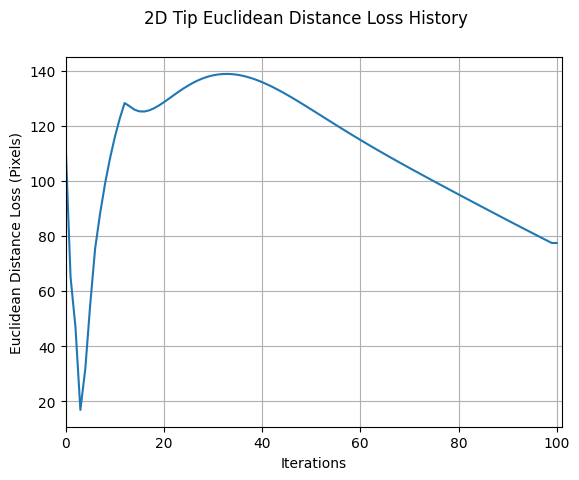

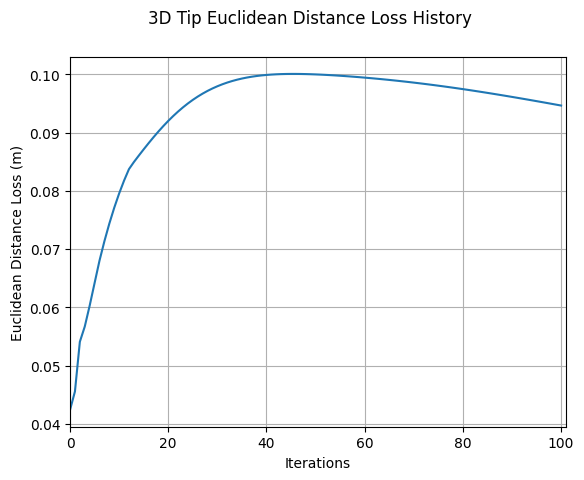

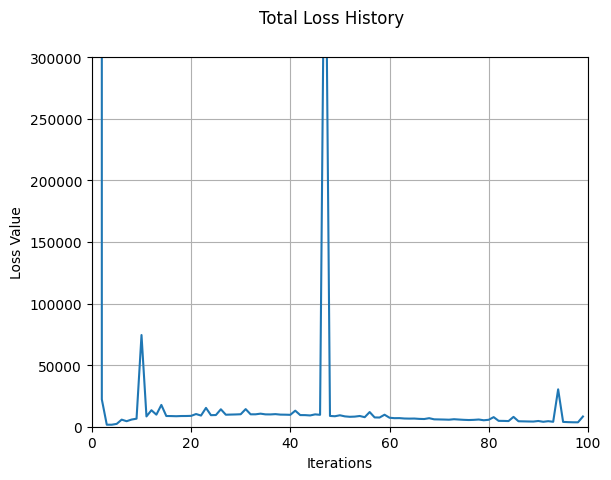

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:57,  1.80s/it, loss=6.57e+3]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:05,  1.89s/it, loss=2.86e+3]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:14,  2.01s/it, loss=2.55e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:23,  2.12s/it, loss=1.15e+3]


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:38,  2.30s/it, loss=1.5e+3] 


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:13<03:49,  2.45s/it, loss=1.48e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:16<04:02,  2.61s/it, loss=1.51e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:19<04:16,  2.79s/it, loss=1.57e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:30,  2.97s/it, loss=1.24e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:26<04:43,  3.16s/it, loss=1.99e+3]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:52,  3.28s/it, loss=1.69e+3]


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:05,  3.47s/it, loss=1.62e+3]


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:18,  3.66s/it, loss=3.67e+3]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:27,  3.81s/it, loss=610]    


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:46<05:37,  3.97s/it, loss=787]


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:48,  4.15s/it, loss=736]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:01,  4.35s/it, loss=1.05e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:11,  4.53s/it, loss=939]    


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:20,  4.70s/it, loss=914]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:28,  4.85s/it, loss=765]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:16<06:37,  5.03s/it, loss=693]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:22<06:50,  5.26s/it, loss=3.48e+3]


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<06:59,  5.45s/it, loss=623]    


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:07,  5.62s/it, loss=8.83e+7]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:40<07:16,  5.82s/it, loss=740]    


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:25,  6.02s/it, loss=2.22e+7]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:53<07:30,  6.17s/it, loss=849]    


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:00<07:36,  6.34s/it, loss=2.84e+3]


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:47,  6.59s/it, loss=617]    


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:14<07:53,  6.77s/it, loss=694]


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<08:00,  6.97s/it, loss=744]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:06,  7.16s/it, loss=648]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:12,  7.34s/it, loss=604]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:16,  7.53s/it, loss=1.01e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:22,  7.73s/it, loss=796]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:01<08:23,  7.87s/it, loss=597]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:26,  8.03s/it, loss=694]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:28,  8.20s/it, loss=637]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:27<08:30,  8.36s/it, loss=792]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:36<08:32,  8.54s/it, loss=1.23e+3]


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:45<08:34,  8.71s/it, loss=681]    


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:39,  8.96s/it, loss=811]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:04<08:40,  9.13s/it, loss=607]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:14<08:41,  9.31s/it, loss=568]


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:24<08:40,  9.46s/it, loss=543]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:34<08:40,  9.65s/it, loss=567]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:44<08:42,  9.86s/it, loss=565]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:41, 10.02s/it, loss=1.15e+3]


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:42, 10.25s/it, loss=923]    


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:50, 10.61s/it, loss=1.28e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:44, 10.71s/it, loss=2.53e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:39, 10.82s/it, loss=548]    


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:50<08:36, 10.98s/it, loss=6.67e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:02<08:34, 11.18s/it, loss=549]    


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:33, 11.42s/it, loss=624]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:30, 11.60s/it, loss=971]


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:25, 11.76s/it, loss=562]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:51<08:21, 11.94s/it, loss=525]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:16, 12.11s/it, loss=4.41e+3]


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:16<08:13, 12.34s/it, loss=942]    


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:29<08:08, 12.52s/it, loss=1.32e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:42<08:03, 12.72s/it, loss=681]    


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:56<07:59, 12.96s/it, loss=612]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:09<07:53, 13.15s/it, loss=2.29e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:23<07:48, 13.39s/it, loss=613]    


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:37<07:39, 13.52s/it, loss=619]


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:51<07:32, 13.71s/it, loss=608]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:05<07:24, 13.88s/it, loss=554]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:14, 14.03s/it, loss=1.26e+3]


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:34<07:07, 14.24s/it, loss=641]    


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:49<06:58, 14.42s/it, loss=849]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:04<06:49, 14.63s/it, loss=877]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:39, 14.79s/it, loss=595]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:35<06:30, 15.01s/it, loss=1.1e+3]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:19, 15.16s/it, loss=870]   


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:09, 15.38s/it, loss=3.22e+3]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:22<05:57, 15.53s/it, loss=533]    


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:46, 15.74s/it, loss=685]


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:33, 15.90s/it, loss=4.44e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:11<05:20, 16.03s/it, loss=540]    


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:07, 16.21s/it, loss=753]


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:56, 16.46s/it, loss=760]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:42, 16.64s/it, loss=542]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:28, 16.78s/it, loss=531]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:36<04:14, 16.93s/it, loss=927]


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<04:00, 17.16s/it, loss=819]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:45, 17.32s/it, loss=636]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:29, 17.50s/it, loss=1.21e+3]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:14, 17.65s/it, loss=601]    


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:58, 17.90s/it, loss=517]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:24<02:42, 18.03s/it, loss=1.03e+3]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:25, 18.14s/it, loss=1.23e+3]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:02<02:08, 18.33s/it, loss=566]    


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:21<01:51, 18.52s/it, loss=1.43e+3]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:40<01:33, 18.70s/it, loss=2.96e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [16:59<01:15, 18.87s/it, loss=684]    


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:19<00:57, 19.25s/it, loss=668]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:39<00:38, 19.48s/it, loss=1.35e+3]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:59<00:19, 19.56s/it, loss=1.2e+3] 


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:19<00:00, 11.00s/it, loss=760]  


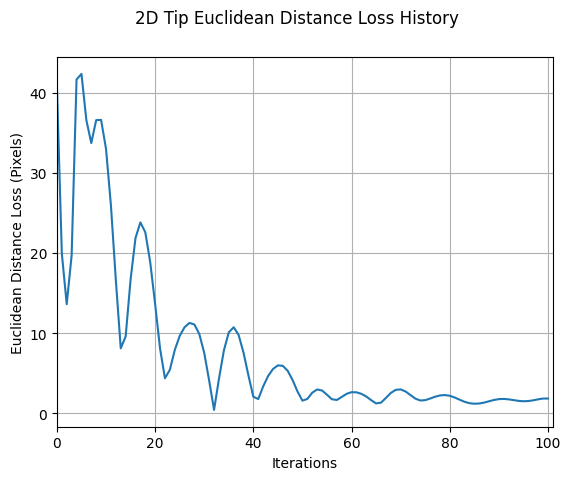

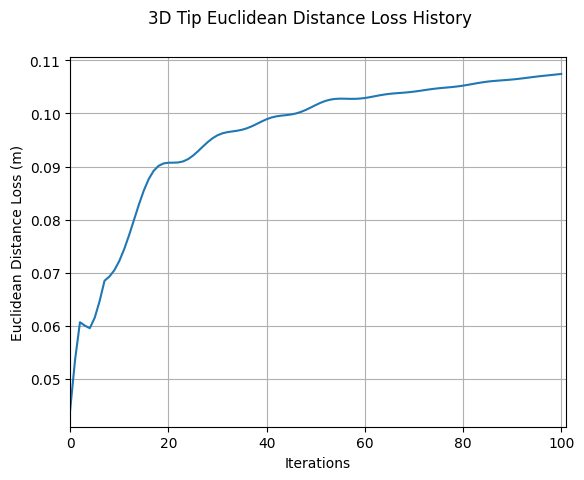

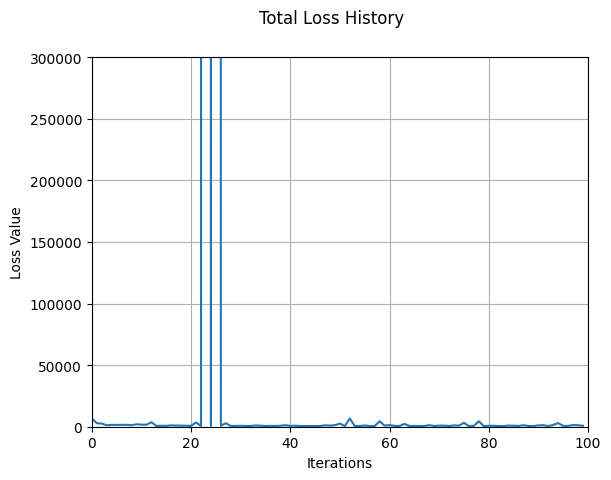

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0


Optimizing:   1%|          | 1/100 [00:01<02:56,  1.78s/it, loss=1.38e+4]


loop_id:  1


Optimizing:   2%|▏         | 2/100 [00:03<03:02,  1.86s/it, loss=1.37e+4]


loop_id:  2


Optimizing:   3%|▎         | 3/100 [00:05<03:14,  2.00s/it, loss=3.19e+3]


loop_id:  3


Optimizing:   4%|▍         | 4/100 [00:08<03:25,  2.14s/it, loss=1.9e+3] 


loop_id:  4


Optimizing:   5%|▌         | 5/100 [00:10<03:40,  2.32s/it, loss=883]   


loop_id:  5


Optimizing:   6%|▌         | 6/100 [00:14<04:06,  2.62s/it, loss=1.96e+3]


loop_id:  6


Optimizing:   7%|▋         | 7/100 [00:17<04:16,  2.76s/it, loss=2.51e+3]


loop_id:  7


Optimizing:   8%|▊         | 8/100 [00:20<04:24,  2.87s/it, loss=3.27e+3]


loop_id:  8


Optimizing:   9%|▉         | 9/100 [00:23<04:35,  3.02s/it, loss=3.92e+3]


loop_id:  9


Optimizing:  10%|█         | 10/100 [00:27<04:47,  3.20s/it, loss=5.17e+4]


loop_id:  10


Optimizing:  11%|█         | 11/100 [00:30<04:55,  3.32s/it, loss=1.4e+3] 


loop_id:  11


Optimizing:  12%|█▏        | 12/100 [00:34<05:06,  3.48s/it, loss=840]   


loop_id:  12


Optimizing:  13%|█▎        | 13/100 [00:38<05:16,  3.64s/it, loss=2.4e+6]


loop_id:  13


Optimizing:  14%|█▍        | 14/100 [00:42<05:26,  3.79s/it, loss=3.81e+3]


loop_id:  14


Optimizing:  15%|█▌        | 15/100 [00:47<05:34,  3.93s/it, loss=1.1e+3] 


loop_id:  15


Optimizing:  16%|█▌        | 16/100 [00:51<05:49,  4.16s/it, loss=1.25e+3]


loop_id:  16


Optimizing:  17%|█▋        | 17/100 [00:56<06:02,  4.36s/it, loss=1.89e+3]


loop_id:  17


Optimizing:  18%|█▊        | 18/100 [01:01<06:10,  4.51s/it, loss=3e+3]   


loop_id:  18


Optimizing:  19%|█▉        | 19/100 [01:06<06:19,  4.69s/it, loss=1.69e+3]


loop_id:  19


Optimizing:  20%|██        | 20/100 [01:11<06:28,  4.86s/it, loss=1.23e+3]


loop_id:  20


Optimizing:  21%|██        | 21/100 [01:17<06:38,  5.04s/it, loss=1.17e+3]


loop_id:  21


Optimizing:  22%|██▏       | 22/100 [01:23<06:51,  5.27s/it, loss=999]    


loop_id:  22


Optimizing:  23%|██▎       | 23/100 [01:28<07:00,  5.46s/it, loss=776]


loop_id:  23


Optimizing:  24%|██▍       | 24/100 [01:34<07:08,  5.64s/it, loss=447]


loop_id:  24


Optimizing:  25%|██▌       | 25/100 [01:41<07:16,  5.82s/it, loss=392]


loop_id:  25


Optimizing:  26%|██▌       | 26/100 [01:47<07:24,  6.01s/it, loss=419]


loop_id:  26


Optimizing:  27%|██▋       | 27/100 [01:54<07:29,  6.16s/it, loss=2.1e+3]


loop_id:  27


Optimizing:  28%|██▊       | 28/100 [02:01<07:39,  6.39s/it, loss=580]   


loop_id:  28


Optimizing:  29%|██▉       | 29/100 [02:07<07:43,  6.53s/it, loss=8.78e+3]


loop_id:  29


Optimizing:  30%|███       | 30/100 [02:15<07:48,  6.70s/it, loss=664]    


loop_id:  30


Optimizing:  31%|███       | 31/100 [02:22<07:56,  6.90s/it, loss=792]


loop_id:  31


Optimizing:  32%|███▏      | 32/100 [02:29<08:02,  7.09s/it, loss=655]


loop_id:  32


Optimizing:  33%|███▎      | 33/100 [02:37<08:05,  7.25s/it, loss=2.11e+4]


loop_id:  33


Optimizing:  34%|███▍      | 34/100 [02:45<08:11,  7.45s/it, loss=3.36e+3]


loop_id:  34


Optimizing:  35%|███▌      | 35/100 [02:53<08:15,  7.62s/it, loss=352]    


loop_id:  35


Optimizing:  36%|███▌      | 36/100 [03:01<08:20,  7.82s/it, loss=1.16e+3]


loop_id:  36


Optimizing:  37%|███▋      | 37/100 [03:10<08:28,  8.08s/it, loss=1.43e+3]


loop_id:  37


Optimizing:  38%|███▊      | 38/100 [03:19<08:30,  8.24s/it, loss=1.16e+3]


loop_id:  38


Optimizing:  39%|███▉      | 39/100 [03:27<08:33,  8.41s/it, loss=1.46e+3]


loop_id:  39


Optimizing:  40%|████      | 40/100 [03:37<08:38,  8.64s/it, loss=456]    


loop_id:  40


Optimizing:  41%|████      | 41/100 [03:46<08:40,  8.82s/it, loss=584]


loop_id:  41


Optimizing:  42%|████▏     | 42/100 [03:55<08:40,  8.98s/it, loss=857]


loop_id:  42


Optimizing:  43%|████▎     | 43/100 [04:05<08:41,  9.16s/it, loss=1.38e+3]


loop_id:  43


Optimizing:  44%|████▍     | 44/100 [04:15<08:45,  9.39s/it, loss=732]    


loop_id:  44


Optimizing:  45%|████▌     | 45/100 [04:25<08:44,  9.54s/it, loss=397]


loop_id:  45


Optimizing:  46%|████▌     | 46/100 [04:35<08:42,  9.68s/it, loss=398]


loop_id:  46


Optimizing:  47%|████▋     | 47/100 [04:45<08:43,  9.87s/it, loss=7.79e+6]


loop_id:  47


Optimizing:  48%|████▊     | 48/100 [04:55<08:42, 10.05s/it, loss=503]    


loop_id:  48


Optimizing:  49%|████▉     | 49/100 [05:06<08:41, 10.22s/it, loss=5.29e+3]


loop_id:  49


Optimizing:  50%|█████     | 50/100 [05:17<08:42, 10.45s/it, loss=1.26e+3]


loop_id:  50


Optimizing:  51%|█████     | 51/100 [05:28<08:39, 10.61s/it, loss=1.07e+3]


loop_id:  51


Optimizing:  52%|█████▏    | 52/100 [05:39<08:36, 10.76s/it, loss=378]    


loop_id:  52


Optimizing:  53%|█████▎    | 53/100 [05:50<08:34, 10.96s/it, loss=1.31e+3]


loop_id:  53


Optimizing:  54%|█████▍    | 54/100 [06:02<08:31, 11.12s/it, loss=1.25e+3]


loop_id:  54


Optimizing:  55%|█████▌    | 55/100 [06:14<08:29, 11.32s/it, loss=2.59e+3]


loop_id:  55


Optimizing:  56%|█████▌    | 56/100 [06:26<08:29, 11.59s/it, loss=993]    


loop_id:  56


Optimizing:  57%|█████▋    | 57/100 [06:38<08:26, 11.78s/it, loss=571]


loop_id:  57


Optimizing:  58%|█████▊    | 58/100 [06:50<08:20, 11.93s/it, loss=1.3e+3]


loop_id:  58


Optimizing:  59%|█████▉    | 59/100 [07:03<08:14, 12.06s/it, loss=336]   


loop_id:  59


Optimizing:  60%|██████    | 60/100 [07:15<08:09, 12.23s/it, loss=334]


loop_id:  60


Optimizing:  61%|██████    | 61/100 [07:28<08:05, 12.45s/it, loss=2.73e+3]


loop_id:  61


Optimizing:  62%|██████▏   | 62/100 [07:42<08:02, 12.69s/it, loss=363]    


loop_id:  62


Optimizing:  63%|██████▎   | 63/100 [07:55<08:00, 12.99s/it, loss=865]


loop_id:  63


Optimizing:  64%|██████▍   | 64/100 [08:09<07:53, 13.17s/it, loss=1.64e+3]


loop_id:  64


Optimizing:  65%|██████▌   | 65/100 [08:23<07:47, 13.35s/it, loss=7.02e+3]


loop_id:  65


Optimizing:  66%|██████▌   | 66/100 [08:37<07:40, 13.55s/it, loss=359]    


loop_id:  66


Optimizing:  67%|██████▋   | 67/100 [08:51<07:33, 13.74s/it, loss=627]


loop_id:  67


Optimizing:  68%|██████▊   | 68/100 [09:05<07:25, 13.93s/it, loss=1.17e+3]


loop_id:  68


Optimizing:  69%|██████▉   | 69/100 [09:20<07:16, 14.09s/it, loss=437]    


loop_id:  69


Optimizing:  70%|███████   | 70/100 [09:34<07:07, 14.25s/it, loss=400]


loop_id:  70


Optimizing:  71%|███████   | 71/100 [09:50<07:01, 14.52s/it, loss=614]


loop_id:  71


Optimizing:  72%|███████▏  | 72/100 [10:05<06:51, 14.69s/it, loss=517]


loop_id:  72


Optimizing:  73%|███████▎  | 73/100 [10:20<06:40, 14.84s/it, loss=441]


loop_id:  73


Optimizing:  74%|███████▍  | 74/100 [10:35<06:30, 15.02s/it, loss=331]


loop_id:  74


Optimizing:  75%|███████▌  | 75/100 [10:51<06:20, 15.22s/it, loss=317]


loop_id:  75


Optimizing:  76%|███████▌  | 76/100 [11:07<06:08, 15.36s/it, loss=332]


loop_id:  76


Optimizing:  77%|███████▋  | 77/100 [11:23<05:57, 15.53s/it, loss=1.23e+4]


loop_id:  77


Optimizing:  78%|███████▊  | 78/100 [11:39<05:45, 15.71s/it, loss=596]    


loop_id:  78


Optimizing:  79%|███████▉  | 79/100 [11:55<05:33, 15.90s/it, loss=3.22e+3]


loop_id:  79


Optimizing:  80%|████████  | 80/100 [12:11<05:20, 16.01s/it, loss=1.47e+3]


loop_id:  80


Optimizing:  81%|████████  | 81/100 [12:28<05:07, 16.20s/it, loss=326]    


loop_id:  81


Optimizing:  82%|████████▏ | 82/100 [12:45<04:54, 16.35s/it, loss=365]


loop_id:  82


Optimizing:  83%|████████▎ | 83/100 [13:02<04:42, 16.59s/it, loss=492]


loop_id:  83


Optimizing:  84%|████████▍ | 84/100 [13:19<04:28, 16.78s/it, loss=1.04e+3]


loop_id:  84


Optimizing:  85%|████████▌ | 85/100 [13:36<04:13, 16.92s/it, loss=323]    


loop_id:  85


Optimizing:  86%|████████▌ | 86/100 [13:54<04:00, 17.17s/it, loss=815]


loop_id:  86


Optimizing:  87%|████████▋ | 87/100 [14:12<03:46, 17.40s/it, loss=330]


loop_id:  87


Optimizing:  88%|████████▊ | 88/100 [14:30<03:30, 17.51s/it, loss=8.75e+5]


loop_id:  88


Optimizing:  89%|████████▉ | 89/100 [14:48<03:14, 17.67s/it, loss=332]    


loop_id:  89


Optimizing:  90%|█████████ | 90/100 [15:06<02:58, 17.82s/it, loss=910]


loop_id:  90


Optimizing:  91%|█████████ | 91/100 [15:25<02:42, 18.06s/it, loss=848]


loop_id:  91


Optimizing:  92%|█████████▏| 92/100 [15:43<02:26, 18.29s/it, loss=381]


loop_id:  92


Optimizing:  93%|█████████▎| 93/100 [16:02<02:09, 18.44s/it, loss=750]


loop_id:  93


Optimizing:  94%|█████████▍| 94/100 [16:21<01:51, 18.62s/it, loss=2.08e+4]


loop_id:  94


Optimizing:  95%|█████████▌| 95/100 [16:40<01:34, 18.81s/it, loss=1.69e+3]


loop_id:  95


Optimizing:  96%|█████████▌| 96/100 [17:00<01:15, 18.99s/it, loss=618]    


loop_id:  96


Optimizing:  97%|█████████▋| 97/100 [17:19<00:57, 19.16s/it, loss=332]


loop_id:  97


Optimizing:  98%|█████████▊| 98/100 [17:39<00:38, 19.35s/it, loss=370]


loop_id:  98


Optimizing:  99%|█████████▉| 99/100 [17:59<00:19, 19.54s/it, loss=345]


loop_id:  99


Optimizing: 100%|██████████| 100/100 [18:19<00:00, 11.00s/it, loss=627]


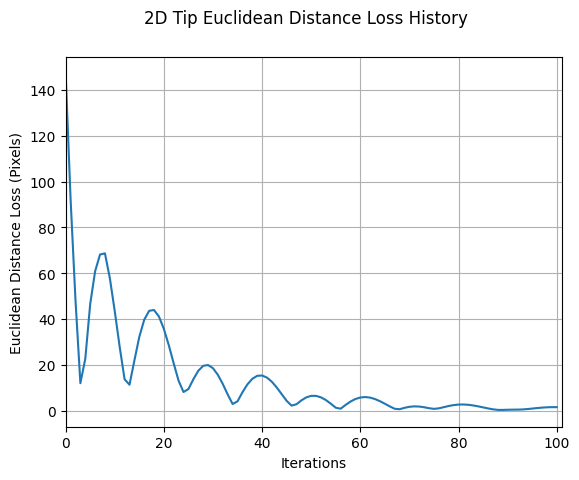

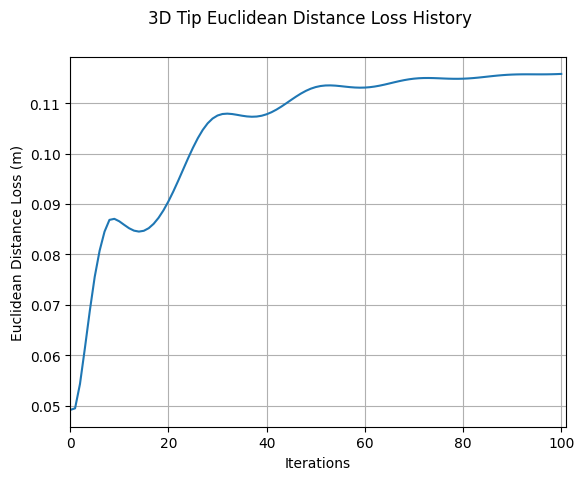

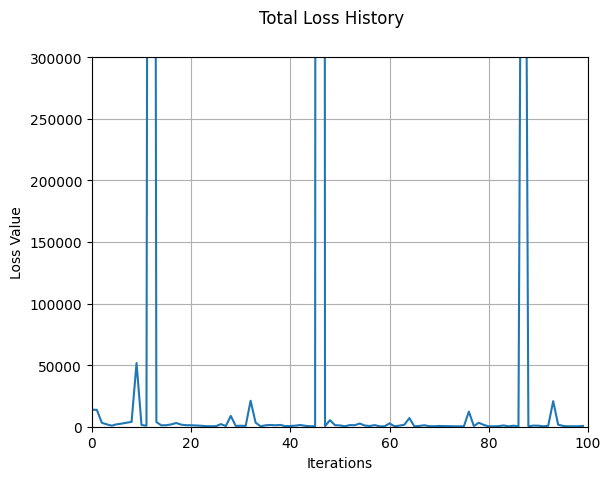

In [13]:
para_init_0 = np.array([0.0365, 0.0036, 0.1202, 0.0056, -0.0166, 0.1645], dtype=np.float32)
para_init_1 = np.array([0.03, 0.0055, 0.0702, 0.0206, -0.0306, 0.1845], dtype=np.float32)
para_init_3 = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815], dtype=np.float32)
para_init_list = [para_init_0, para_init_1, para_init_3] + vectors
print(len(para_init_list))

for i, para_init in enumerate(para_init_list):
    excecute(para_init, i+1)